# The `ZeroSumNormal` distribution and categorical coding in Bayesian regression 

**Authors: [Benjamin T. Vincent](https://github.com/drbenvincent) and [Adrian Seyboldt](https://github.com/aseyboldt)**

In [1]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import patsy
import pymc3 as pm
import statsmodels.api as sm
import theano.tensor as tt

In [2]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
plt.rcParams.update({"font.size": 14})
az.style.use("arviz-darkgrid")
seed = 1234
rng = np.random.default_rng(seed)

## Categorical coding in a Frequentist setting
In order to get a good appreciation for why the `ZeroSumNormal` distribution is useful, we're going to go back to categorical coding basics, in a Frequentist setting. We will start by considering a very simple toy dataset:

In [3]:
df = pd.DataFrame(
    {
        "group": ["A", "A", "A", "B", "B", "B", "C", "C", "C"],
        "y": [-2.1, -2.2, -2.1, 1.1, 1.2, 1.05, 3.1, 3.01, 2.95],
    }
)
df

group     y
0     A -2.10
1     A -2.20
2     A -2.10
3     B  1.10
4     B  1.20
5     B  1.05
6     C  3.10
7     C  3.01
8     C  2.95

### Dummy coding
The default, [dummy coding](https://patsy.readthedocs.io/en/latest/API-reference.html#patsy.Treatment) (aka Treatment coding), sets one factor level (typically the first, i.e. group 'A') as an intercept, and then models the remaining factor levels as deflections from that intercept. This could be useful if group A represents control participants, group B represents participants exposed to caffeine, and group C represents participants exposed to Russian techno music.

Let's see this in action in a Frequentist setting using [patsy](https://patsy.readthedocs.io/en/latest/index.html) and [statsmodels](https://www.statsmodels.org).

In [4]:
y, X = patsy.dmatrices("y ~ C(group, Treatment)", df, return_type="dataframe")
display(X)

Intercept  C(group, Treatment)[T.B]  C(group, Treatment)[T.C]
0        1.0                       0.0                       0.0
1        1.0                       0.0                       0.0
2        1.0                       0.0                       0.0
3        1.0                       1.0                       0.0
4        1.0                       1.0                       0.0
5        1.0                       1.0                       0.0
6        1.0                       0.0                       1.0
7        1.0                       0.0                       1.0
8        1.0                       0.0                       1.0

Above, we can see the whole design matrix, as this is a very small dataset. 

In [5]:
dummy_model = sm.OLS(y, X)
dummy_result = dummy_model.fit()
display(dummy_result.params)

Intercept                  -2.133333
C(group, Treatment)[T.B]    3.250000
C(group, Treatment)[T.C]    5.153333
dtype: float64

Above we have the OLS parameter estimates. We can understand the coding scheme more in the plot below - we visualise the data alongside the group mean estimates.

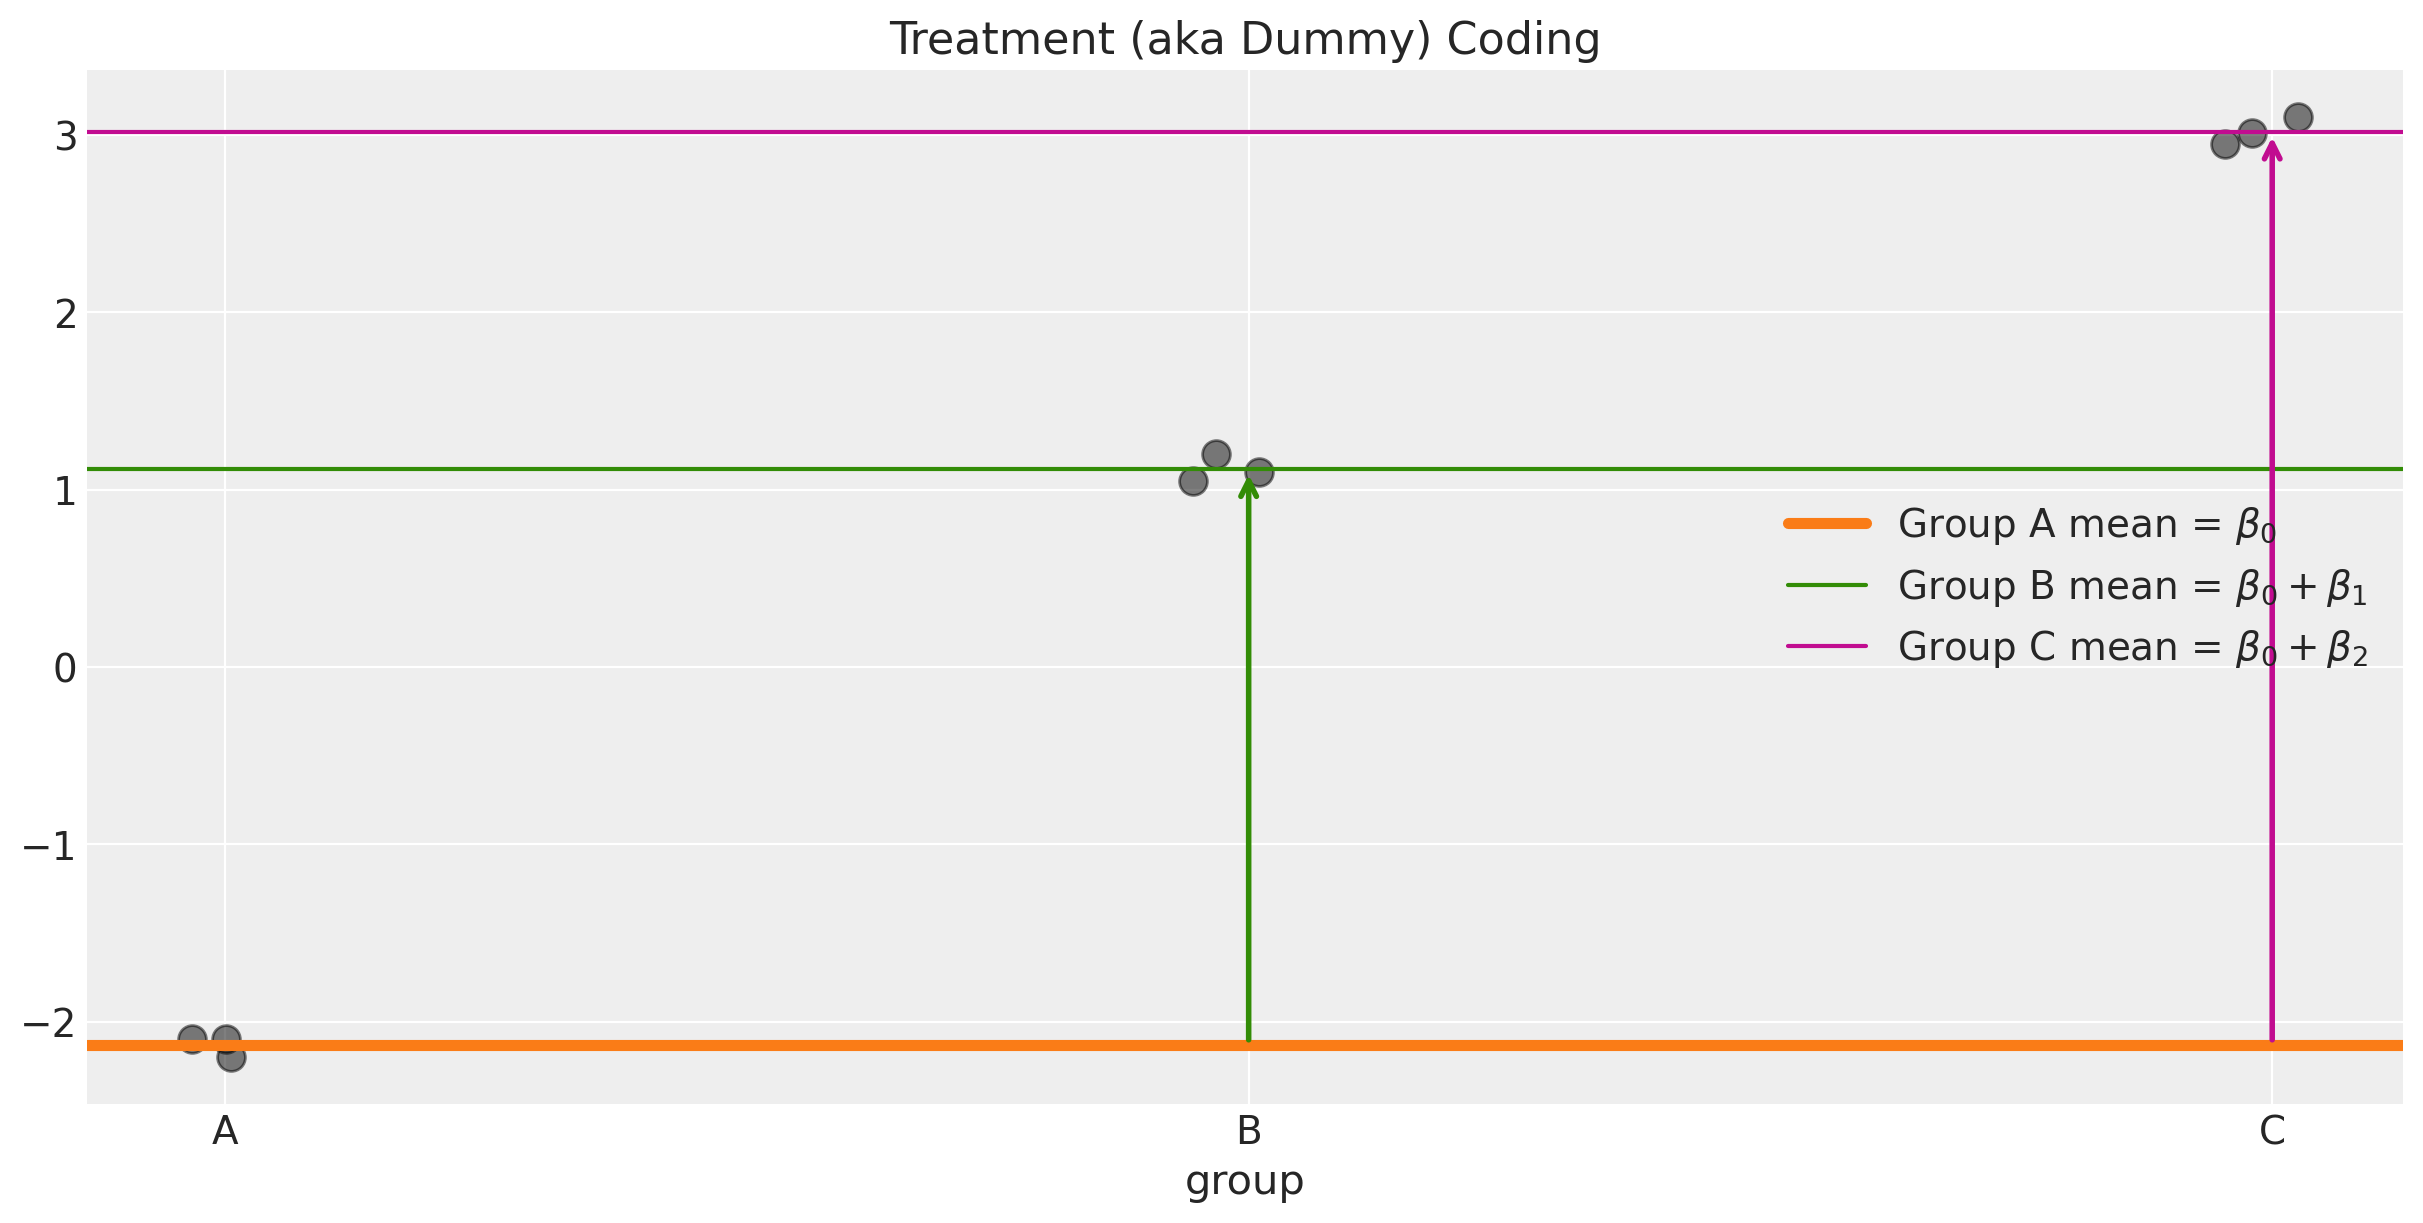

In [6]:
fig, ax = plt.subplots(figsize=(12, 6))
x, xlevels = pd.factorize(df.group)
x_jitter = np.random.normal(scale=0.03, size=df.shape[0])
ax.scatter(x + x_jitter, df.y, color="k", alpha=0.5, s=10 ** 2)
ax.set(xticks=[0, 1, 2], xticklabels=xlevels, xlabel="group")

ax.axhline(y=dummy_result.params[0], label=r"Group A mean = $\beta_0$", c="C1", lw=4)
ax.axhline(
    y=dummy_result.params[0] + dummy_result.params[1],
    label=r"Group B mean = $\beta_0 + \beta_1$",
    c="C2",
)
ax.axhline(
    y=dummy_result.params[0] + dummy_result.params[2],
    label=r"Group C mean = $\beta_0 + \beta_2$",
    c="C3",
)

ax.annotate(
    "",
    xy=(1, dummy_result.params[0] + dummy_result.params[1]),  # end point
    xytext=(1, dummy_result.params[0]),  # start point
    arrowprops=dict(arrowstyle="->", color="C2", lw=2),
)

ax.annotate(
    "",
    xy=(2, dummy_result.params[0] + dummy_result.params[2]),  # end point
    xytext=(2, dummy_result.params[0]),  # start point
    arrowprops=dict(arrowstyle="->", color="C3", lw=2),
)

ax.legend()
ax.set(title="Treatment (aka Dummy) Coding");

So we see that in this dummy coding scheme:
- group A mean (the intercept) is given by $\beta_0$.
- group B mean is given by the deflection $\beta_1$ from the intercept (i.e. $\beta_0+\beta_1$).
- group C mean is given by the deflection $\beta_2$ from the intercept (i.e. $\beta_0+\beta_2$).

### Sum (or deviation) coding
While dummy coding can be useful in many situations, there are a number of other ways to represent categorical variables. For example, [sum coding](https://patsy.readthedocs.io/en/latest/API-reference.html#patsy.Sum) can be useful in situations where none of the groups could be considered as 'special' and we are perhaps more interested in examining groups means in terms of deflections from a grand mean.

In [7]:
# Create design matrix
y, X = patsy.dmatrices("y ~ C(group, Sum)", df, return_type="dataframe")
display(X)

Intercept  C(group, Sum)[S.A]  C(group, Sum)[S.B]
0        1.0                 1.0                 0.0
1        1.0                 1.0                 0.0
2        1.0                 1.0                 0.0
3        1.0                 0.0                 1.0
4        1.0                 0.0                 1.0
5        1.0                 0.0                 1.0
6        1.0                -1.0                -1.0
7        1.0                -1.0                -1.0
8        1.0                -1.0                -1.0

Wecan see that the design matrix is different for sum coding, compared to dummy coding.

In [8]:
# Frequentist parameter estimates
sum_model = sm.OLS(y, X)
sum_result = sum_model.fit()
display(sum_result.params)

Intercept             0.667778
C(group, Sum)[S.A]   -2.801111
C(group, Sum)[S.B]    0.448889
dtype: float64

We can also see that the regression coefficients are different from what we obtained from dummy coding. Let's try to get a better understanding of this with another visualisation.

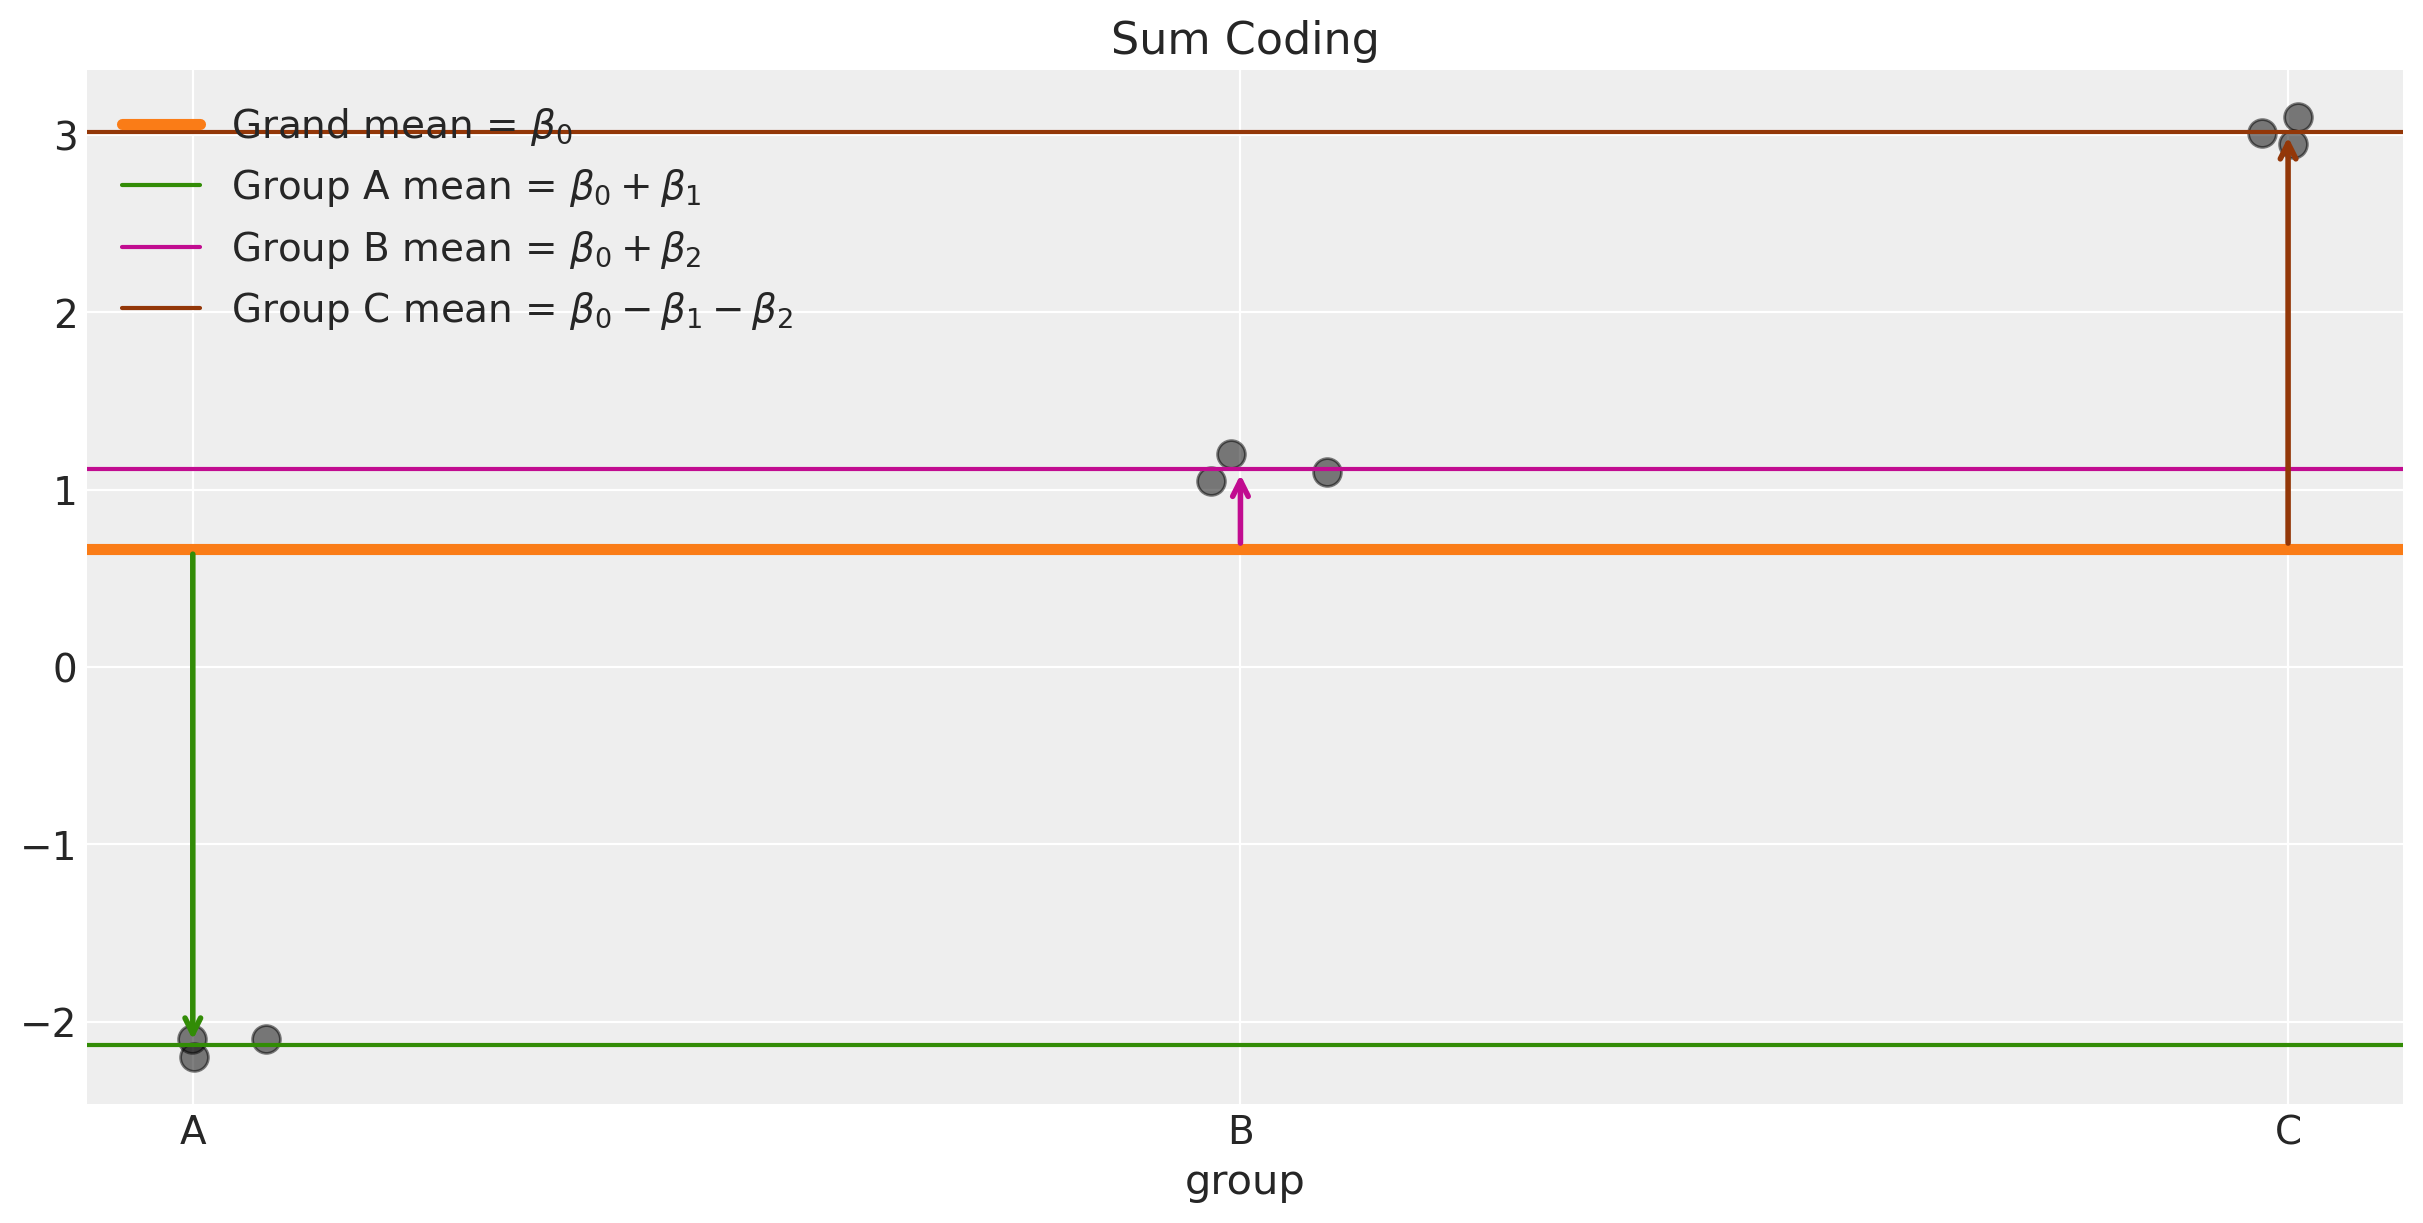

In [9]:
fig, ax = plt.subplots(figsize=(12, 6))
x, xlevels = pd.factorize(df.group)
x_jitter = np.random.normal(scale=0.05, size=df.shape[0])
ax.scatter(x + x_jitter, df.y, color="k", alpha=0.5, s=10 ** 2)
ax.set(xticks=[0, 1, 2], xticklabels=xlevels, xlabel="group")

ax.axhline(y=sum_result.params[0], label=r"Grand mean = $\beta_0$", c="C1", lw=4)
ax.axhline(
    y=sum_result.params[0] + sum_result.params[1],
    label=r"Group A mean = $\beta_0 + \beta_1$",
    c="C2",
)
ax.axhline(
    y=sum_result.params[0] + sum_result.params[2],
    label=r"Group B mean = $\beta_0 + \beta_2$",
    c="C3",
)
ax.axhline(
    y=sum_result.params[0] - sum_result.params[1] - sum_result.params[2],
    label=r"Group C mean = $\beta_0 - \beta_1 - \beta_2$",
    c="C4",
)

ax.annotate(
    "",
    xy=(0, sum_result.params[0] + sum_result.params[1]),  # end point
    xytext=(0, sum_result.params[0]),  # start point
    arrowprops=dict(arrowstyle="->", color="C2", lw=2),
)

ax.annotate(
    "",
    xy=(1, sum_result.params[0] + sum_result.params[2]),  # end point
    xytext=(1, sum_result.params[0]),  # start point
    arrowprops=dict(arrowstyle="->", color="C3", lw=2),
)

ax.annotate(
    "",
    xy=(2, sum_result.params[0] - sum_result.params[1] - sum_result.params[2]),  # end point
    xytext=(2, sum_result.params[0]),  # start point
    arrowprops=dict(arrowstyle="->", color="C4", lw=2),
)

ax.legend()
ax.set(title="Sum Coding");

So we see that in this sum coding scheme:
- grand mean is given by $\beta_0$
- group A mean is given by a deflection $\beta_1$ from the grand mean (i.e. $\beta_0 + \beta_1$).
- group B mean is given by the deflection $\beta_2$ from the grand mean (i.e. $\beta_0+\beta_2$).
- group C mean is given by the deflection $-\beta_1 - \beta_2$ from the grand mean (i.e. $\beta_0 - \beta_1 - \beta_2$).

**Important point 1:** Regardless of the coding scheme, the same answers (estimates of group means) are arrived at. The values of the parameters are different, but that is just because they encode different things - they have different interpretations. Let's confirm that by examing the estimated group means from the dummy coding and the sum coding frequentists models...

In [10]:
# Group A mean estimates
dummy_group_A = dummy_result.params[0]
sum_group_A = sum_result.params[0] + sum_result.params[1]
np.isclose(dummy_group_A, sum_group_A)

True

In [11]:
# Group B mean estimates
dummy_group_B = dummy_result.params[0] + dummy_result.params[1]
sum_group_B = sum_result.params[0] + sum_result.params[2]
np.isclose(dummy_group_B, sum_group_B)

True

In [12]:
# Group C mean estimates
dummy_group_C = dummy_result.params[0] + dummy_result.params[2]
sum_group_C = sum_result.params[0] - sum_result.params[1] - sum_result.params[2]
np.isclose(dummy_group_C, sum_group_C)

True

**Important point 2:** In the Frequentist setting, if we have $G$ groups, then we will estimate $G$ parameters. For example, in this sum (aka deviation coding) we have 3 groups (for this dataset) and we have 3 parameters:
- $\beta_0$: the grand mean
- $\beta_1$: group A mean, relative to the grand mean
- $\beta_2$: group B mean, relative to the grand mean
- and the group C mean is not a free variable as it is a function of $\beta_0, \beta_1$ and $\beta_2$. 

## Categorical coding in a Bayesian setting
In a Bayesian setting, things are different:

1. The choice of coding scheme _does_ effect the answers (estimate of group means) **because we have priors**. For example, in dummy coding, group means B and C are modelled as deflections from the group A mean, but in sum coding group means are modelled as deflectsion from the grand mean. If we were to place even a mildly informative prior upon these deflections then the numerical estimates of the groups means _will_ depend upon the categorical coding scheme used. This is because of the shrinkage affect of the prior.

2. We are also freer in terms of how we code categorical variables. For example we _can_ estimate $g+1$ parameters, such as a grand mean and $g$ group means, **because we have priors to constrain the parameters**.

The rest of this notebook expands upon these core points, focussing on the situation where something akin to sum coding is useful.

## Mean + deflection coding

One very useful and popular approach is with the "intercept + deflections" approach. We are going to make a small change in our notation now and refer to these as $intercept$ and $\delta$ parameters. A model (with $J=3$ groups, for example) using this approach could be described as

$$
y_i \sim \mathrm{Normal}( intercept + \delta_1 x_{i,1} + \delta_2 x_{i,2} + \delta_3 x_{i,3}, \sigma)
$$

where we constrain the sum of the deflections to sum to zero

$$
\Sigma_{j=1}^J \delta_j = 0
$$

One advantage of this scheme is that we can separate out the role of the $intercept$ and the deflections $\delta_1, \ldots, \delta_3$. For example, we can define priors over the deflections $\delta_1, \ldots, \delta_3$ that provide varying degrees of shrinkage, whatever is suitable in a given modelling context.

This "intercept + deflections" approach crops up in wide range of modelling situations, but one of the practical issues is how to impose the sum to zero constraint ($\Sigma_{j=1}^J \delta_j = 0$) on the deflections? As we will see, one way is to manually impose a sum to zero constraint, but this notebook introduced the `ZeroSumNormal` distribution. This is an output of [PyMC Labs](https://www.pymc-labs.io/) who regularly use this in their consulting work - most of the work was done by [Adrian Seyboldt](https://github.com/aseyboldt). 

This allows you to define a prior over the deflections as:

$$
\delta_1, \delta_2, \delta_3 = \mathrm{ZeroSumNormal}(\sigma)
$$

where $\sigma$ could be a constant or another prior distribution, such as a HalfNormal or HalfCauchy.

### Simulate data
To make it easy to compare parameter estimates to ground truth, we will generate data from a model where group means are (zero sum) deflections from an intercept.

In [13]:
true = {
    "intercept": 2,
    "δ": np.array([-1.5, 2, -0.5]),  # note that the deflections sum to zero
    "sd": 0.2,
}
N = 30
data = {"group": [], "y": []}

for i, mean in enumerate(true["δ"]):
    data["group"].extend(np.repeat(i, N))
    data["y"].extend(true["intercept"] + rng.normal(true["δ"][i], true["sd"], N))

df = pd.DataFrame(data)

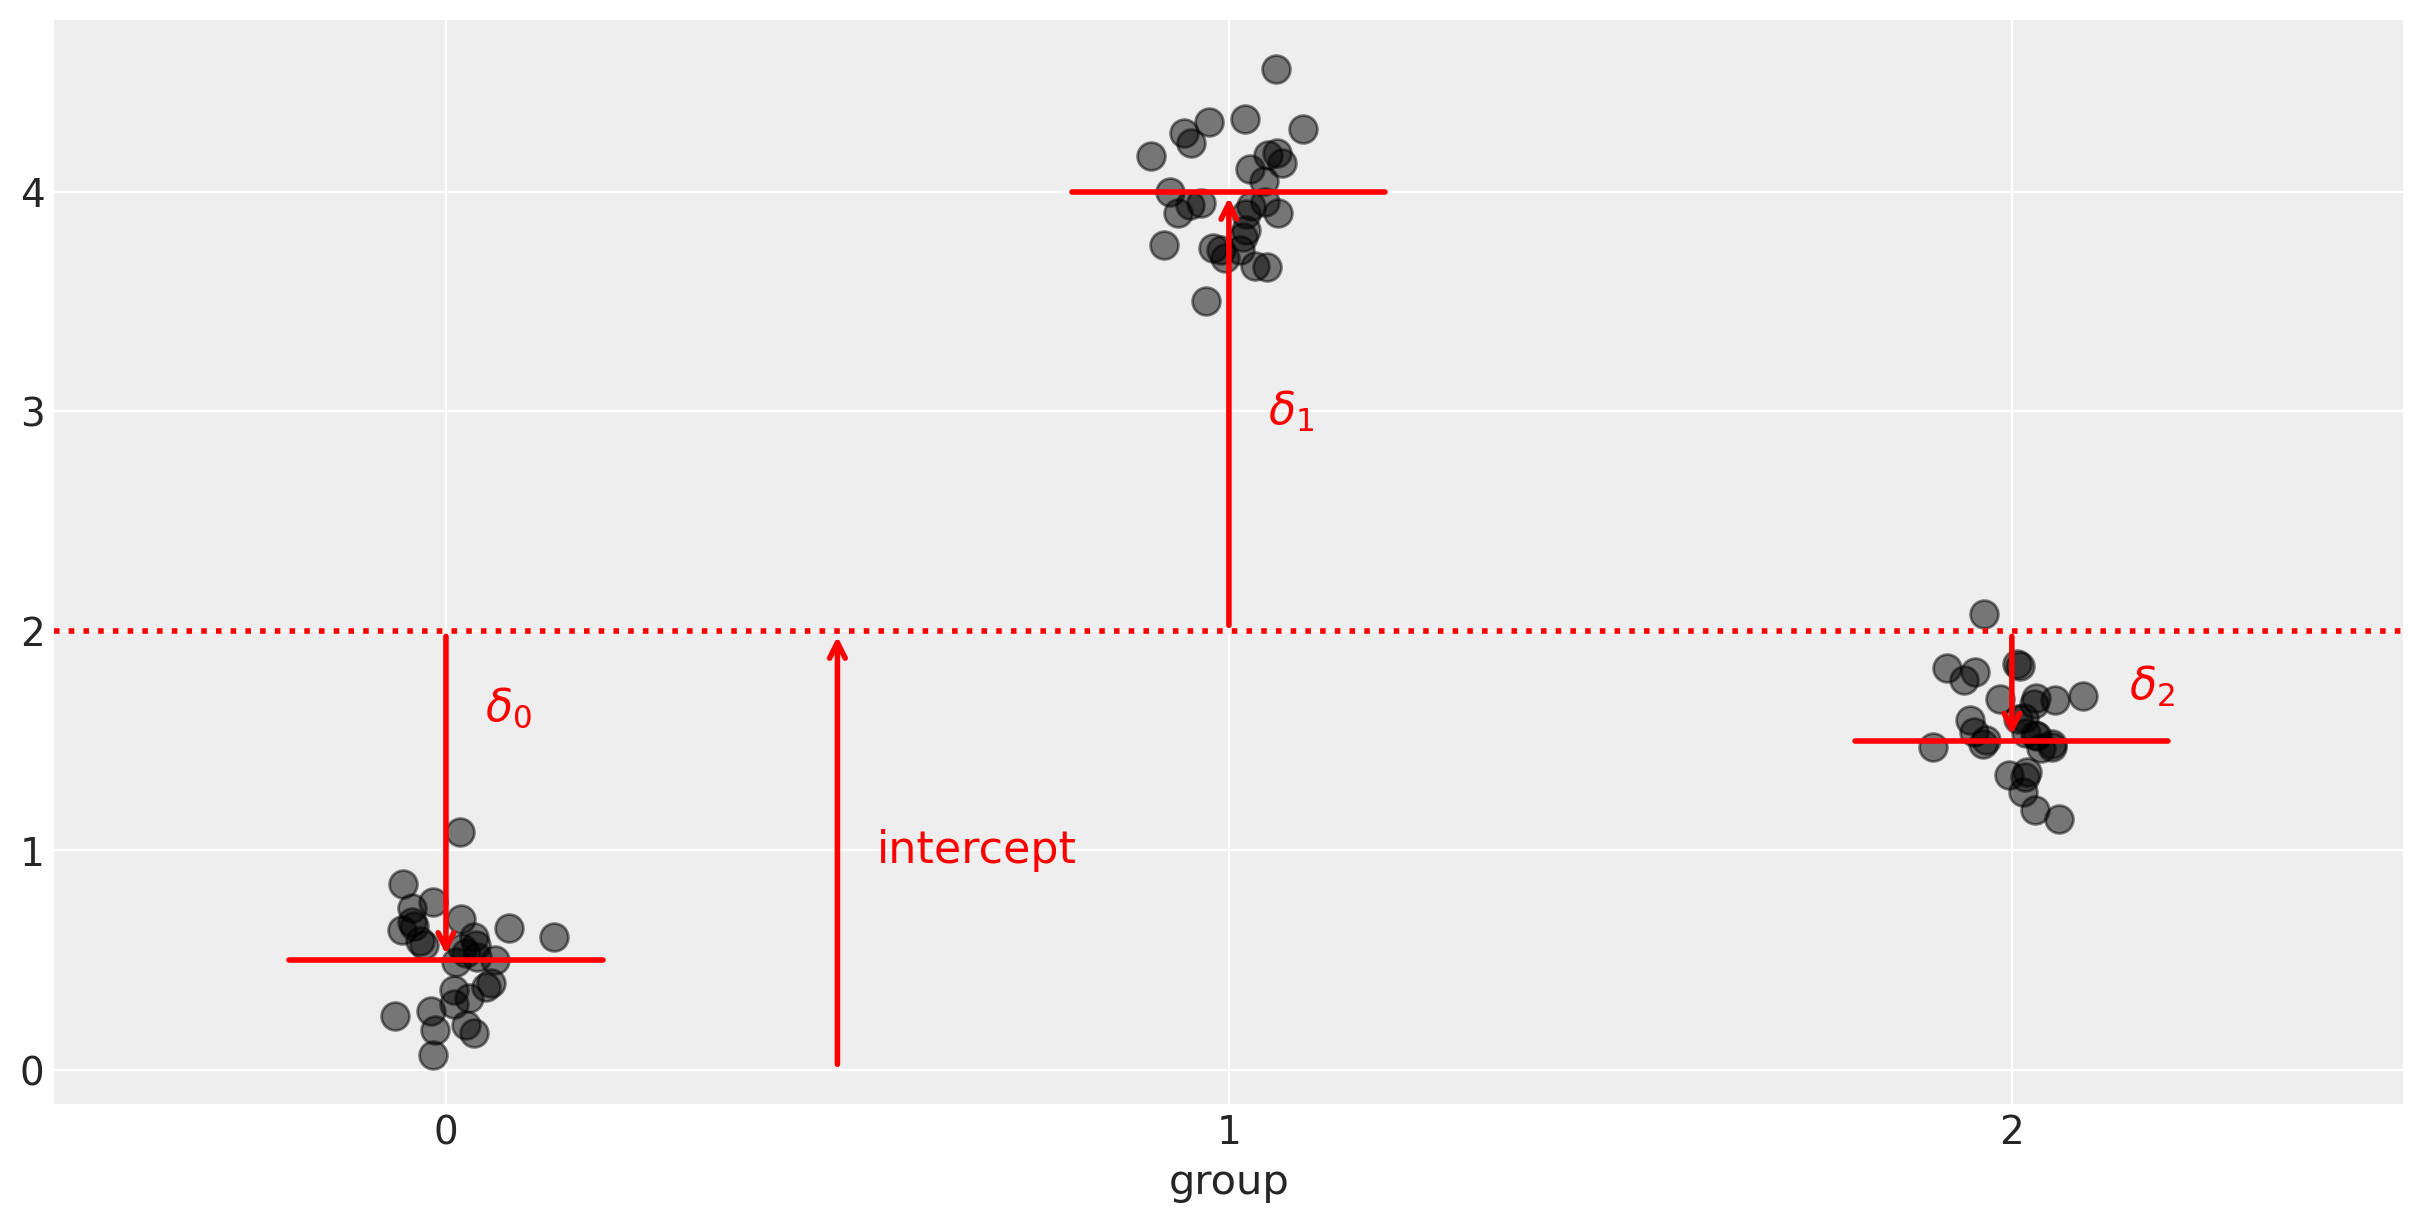

In [14]:
def plot_data(df, annotate=True):
    fig, ax = plt.subplots(figsize=(12, 6))

    x, xlevels = pd.factorize(df.group)

    # data points
    x_jitter = np.random.normal(scale=0.05, size=df.shape[0])
    ax.scatter(x + x_jitter, df.y, color="k", alpha=0.5, s=10 ** 2)

    if annotate:
        for i, group in enumerate([0, 1, 2]):
            # arrows
            ax.annotate(
                "",
                xy=(i, true["intercept"] + true["δ"][i]),  # end point
                xytext=(i, true["intercept"]),  # start point
                arrowprops=dict(arrowstyle="->", color="r", lw=2),
            )
            # horizontal line
            ax.plot(
                [i - 0.2, i + 0.2],
                [true["intercept"] + true["δ"][i], true["intercept"] + true["δ"][i]],
                c="r",
                lw=2,
            )

        # intercept arrow
        ax.annotate(
            "",
            xy=(0.5, true["intercept"]),  # end point
            xytext=(0.5, 0),  # start point
            arrowprops=dict(arrowstyle="->", color="r", lw=2),
        )
        # intercept line
        ax.axhline(y=true["intercept"], ls=":", c="r", lw=2)

        text_kwargs = dict(ha="left", va="center", fontsize=16, color="red")
        plt.text(0.55, 1.0, "intercept", **text_kwargs)
        plt.text(0.05, 1.65, r"$\delta_0$", **text_kwargs)
        plt.text(1.05, 3.0, r"$\delta_1$", **text_kwargs)
        plt.text(2.15, 1.75, r"$\delta_2$", **text_kwargs)

    ax.set(xlim=(-0.5, 2.5), xticks=np.unique(x), xlabel="group")


plot_data(df, annotate=True)

This is the simple dataset we will be modelling. One continuous outcome variable and one categorical predictor variable with 3 levels.

### Naive intercept + deflection model
In this model, we can estimate a population level intercept term and the means of each group are modelled as deflections from this population level intercept term. Note that we have $g=3$ groups, but we are modelling $4$ parameters (an intercept and 3 group deflections). We are able to do this because the prior on the deflections has a regularising/shrinkage effect and is able to contrain the posterior.

The model below is the simplest way to implement this, however we will see that this is problematic.

In [15]:
with pm.Model(coords={"groups": [0, 1, 2]}) as naive_model:
    # priors
    intercept = pm.Normal("intercept", 0, 10)
    δ = pm.Normal("δ", 0, 1, dims="groups")
    sd = pm.HalfNormal("sd", 10)
    # likelihood
    obs = pm.Normal("obs", δ[df["group"]] + intercept, sd, observed=df["y"])
    trace_naive = pm.sample(return_inferencedata=True, random_seed=seed)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sd, δ, intercept]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 18 seconds.
There were 14 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.


We can see that we have sampling problems here. We have divergences, and we have a very low effective sample size.

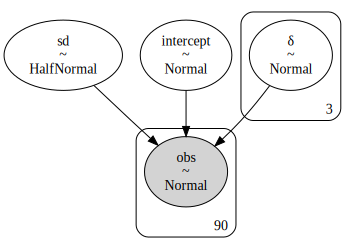

In [16]:
pm.model_graph.model_to_graphviz(naive_model)

This trace plots reflect these sampling problems.

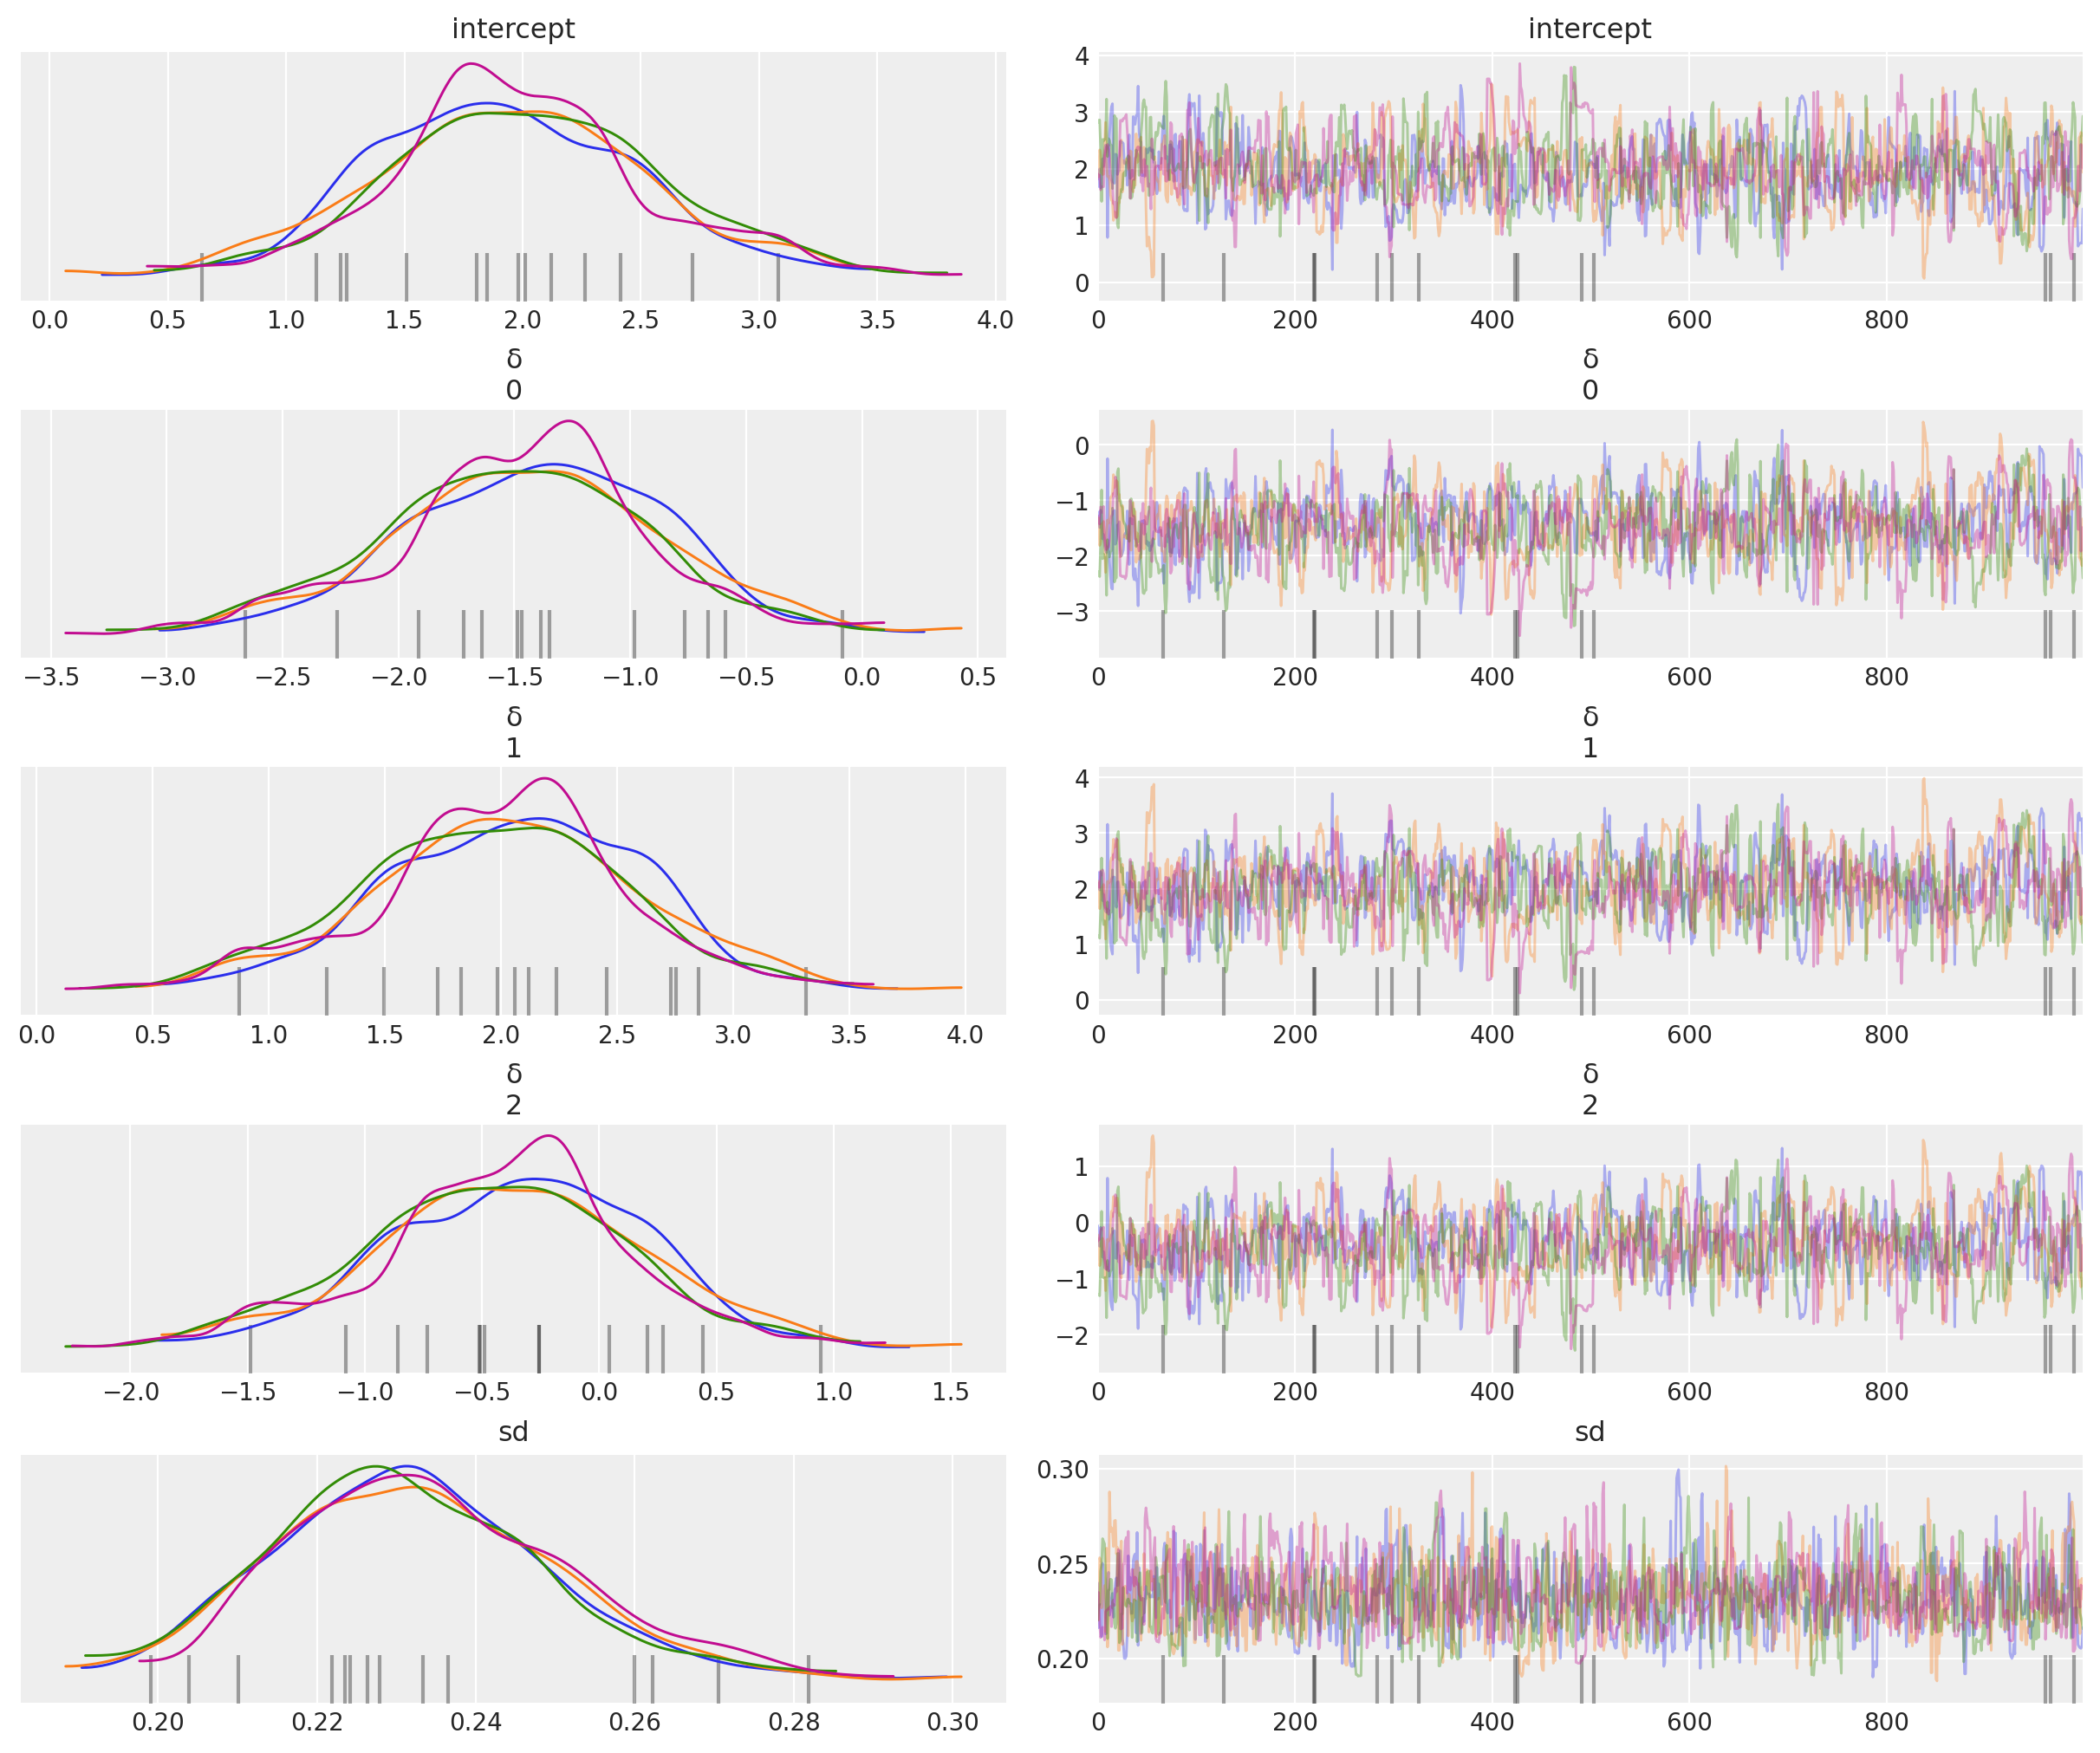

In [17]:
az.plot_trace(trace_naive, compact=False);

And we have very high parameter correlations, which is almost always a warning sign. 

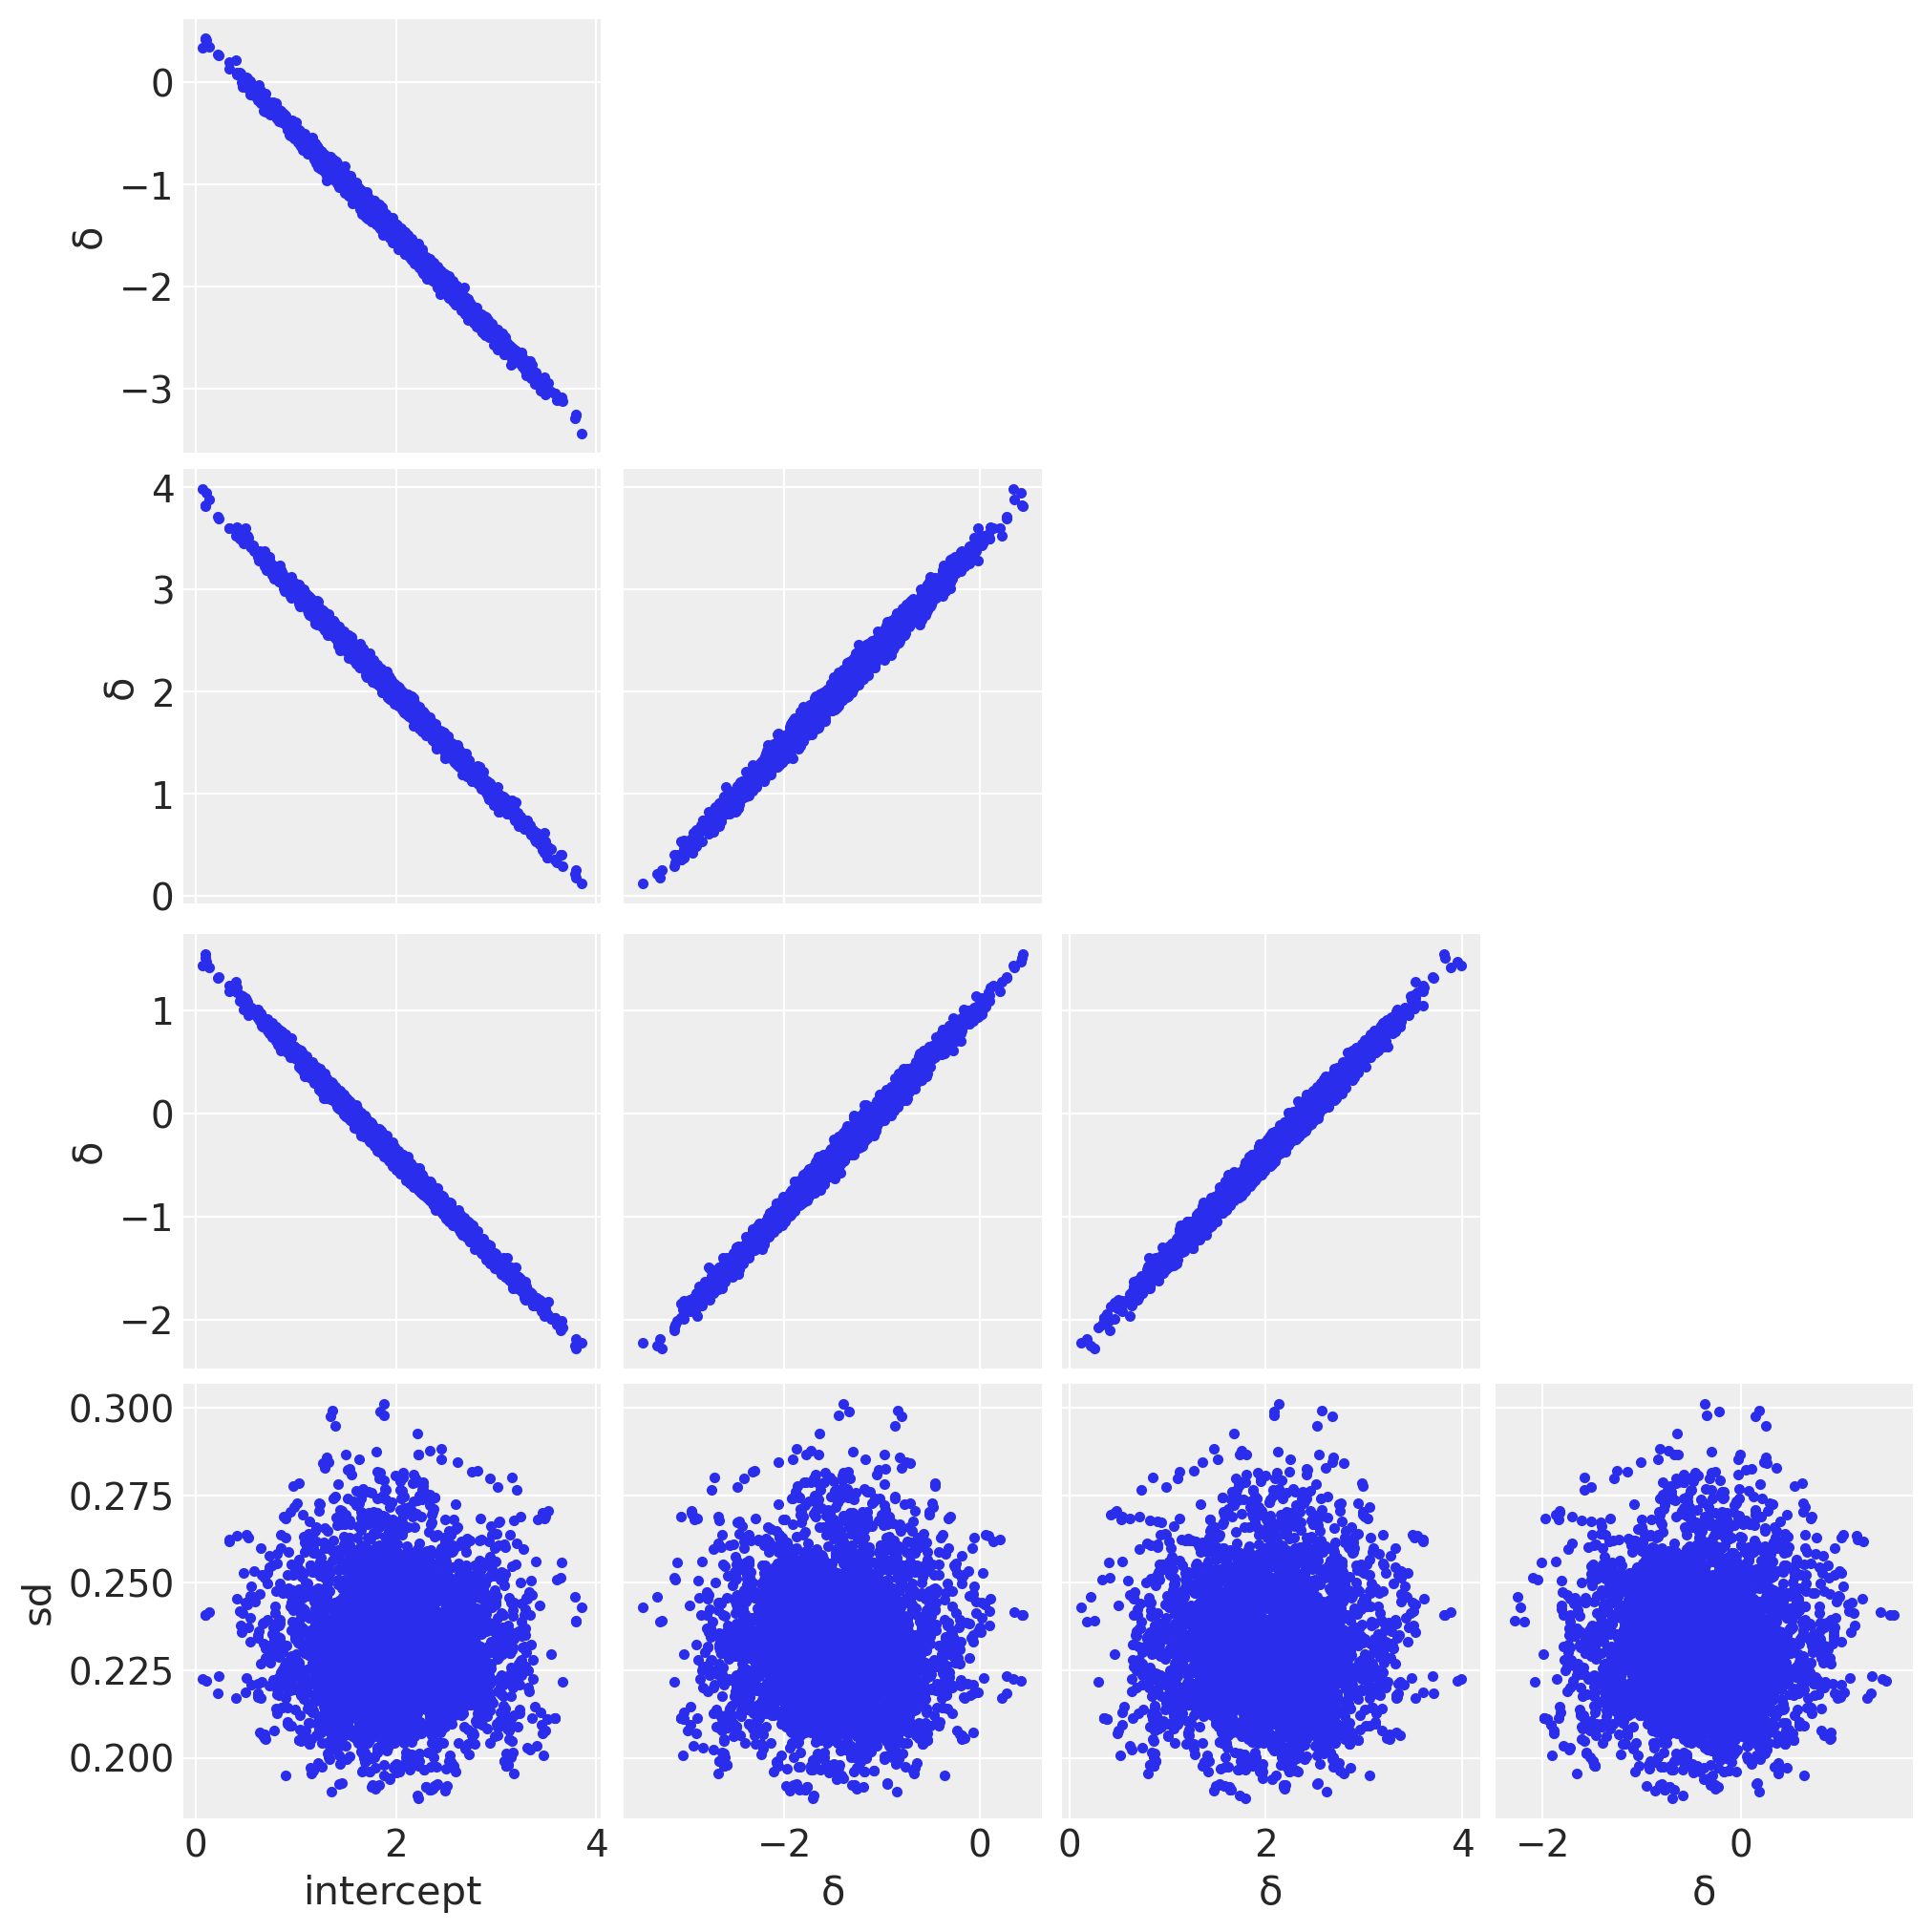

In [18]:
az.plot_pair(trace_naive, figsize=(10, 10));

You might initially think that the posterior prediction is reasonable because the posteriors are centered on the true parameter values. But if we look at the scale, we can see that the posteriors are very broad. We should be able to do better than this.

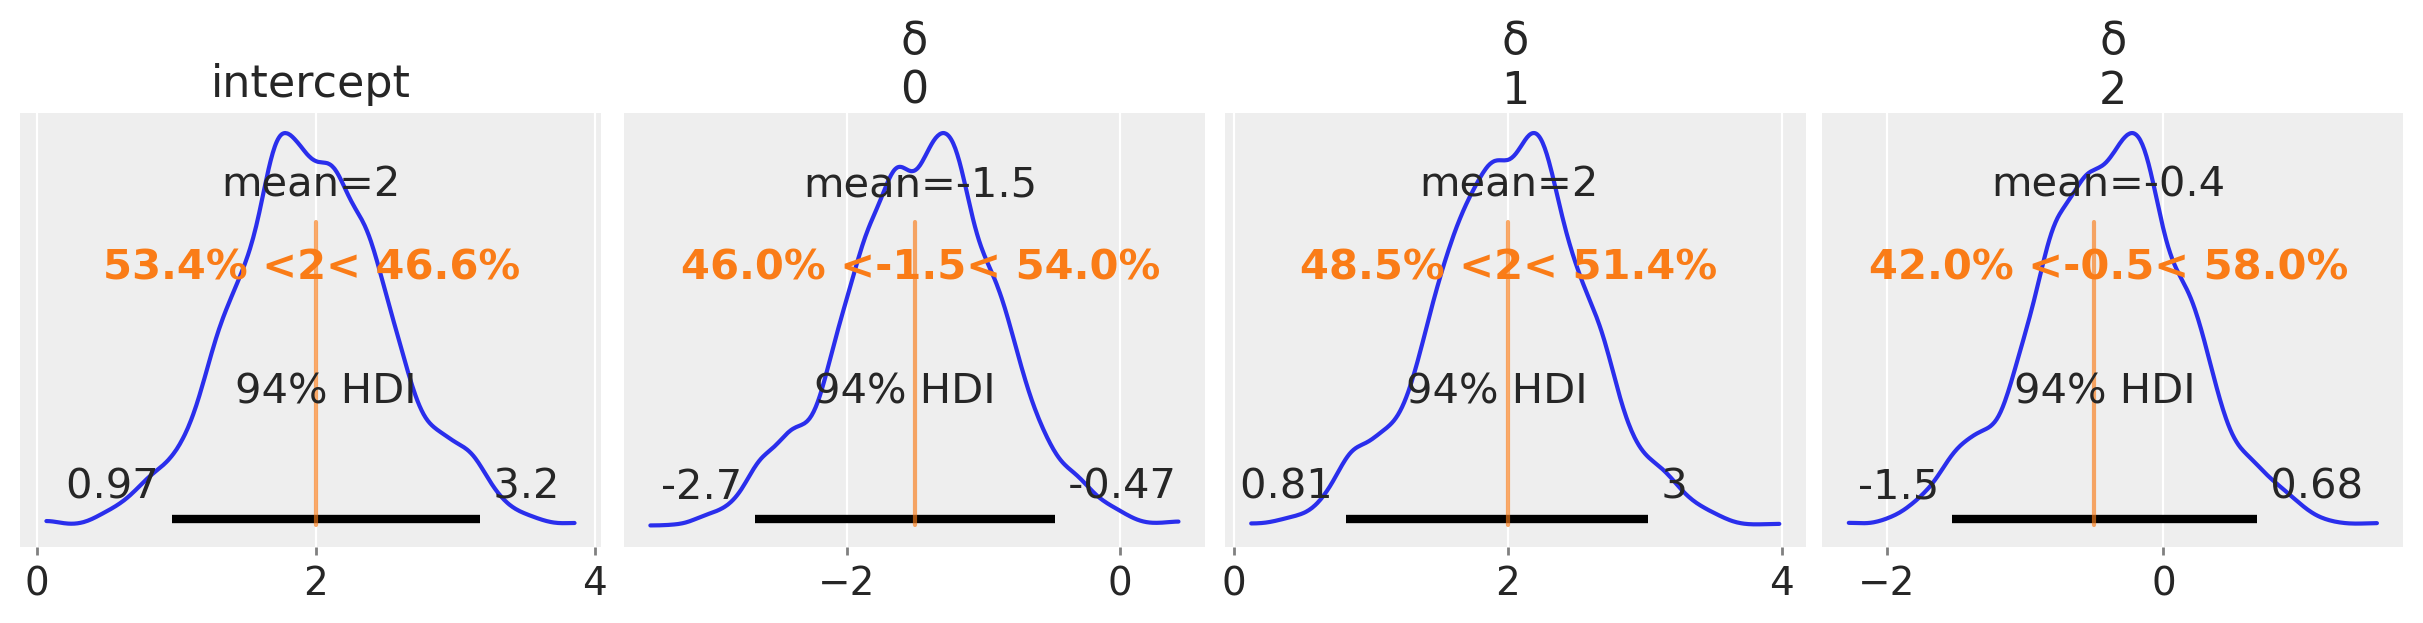

In [19]:
vals = [true["intercept"]] + list(true["δ"])
az.plot_posterior(trace_naive, var_names=["intercept", "δ"], ref_val=vals, figsize=(12, 3));

How did this model do?
- MCMC chain mixing is not ideal and we have low effective sample size ❌
- There are many divergences ❌
- Posterior for the intercept and deflection parameters are highly correlated ❌
- Parameter recovery is reasonable in that posteriors are centered on the true values ✅
- But the precision of the posterior estimate is quite high ❌ See below to see that more precise posteriors are achievable.

If we had set a very wide Normal, or an uninformative prior, then this model would totally have failed. It was saved (somewhat) by the regularising effect of the Normal priors (with low-ish) std.

In order to make progress here, we must add in further constraints. More specifically, we should add the constraint that the deflections sum to zero. This will force the intercept parameter to the mean of the group means in order to satisfy the constraint that the deflections sum to zero. This is implemented in the next model.

### Manual sum to zero model
This model manually enforces a sum to zero constraint with the idea that the model will no longer be over-parameterized.

In [20]:
with pm.Model(coords={"groups": [0, 1, 2]}) as better_model:
    # priors
    _intercept = pm.Normal("_intercept", 0, 10)
    _δ = pm.Normal("_δ", 0, 1, dims="groups")
    sd = pm.HalfNormal("sd", 10)
    # manually enforce sum to zero constraint
    m = tt.mean(_δ)
    intercept = pm.Deterministic("intercept", _intercept + m)
    δ = pm.Deterministic("δ", _δ - m)
    # likelihood
    obs_δ = δ[df["group"].values] + intercept
    obs = pm.Normal("obs", obs_δ, sd, observed=df["y"].values)
    trace_better = pm.sample(return_inferencedata=True, random_seed=seed)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sd, _δ, _intercept]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 18 seconds.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.8910260839518078, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.


We see that we still have divergences and low effective samples.

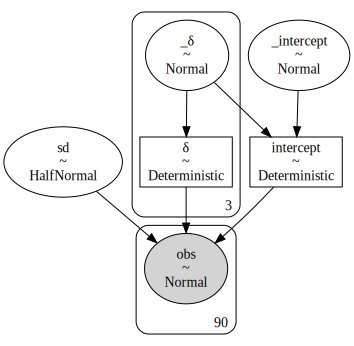

In [21]:
pm.model_graph.model_to_graphviz(better_model)

And these problems are refelected in the trace plot.

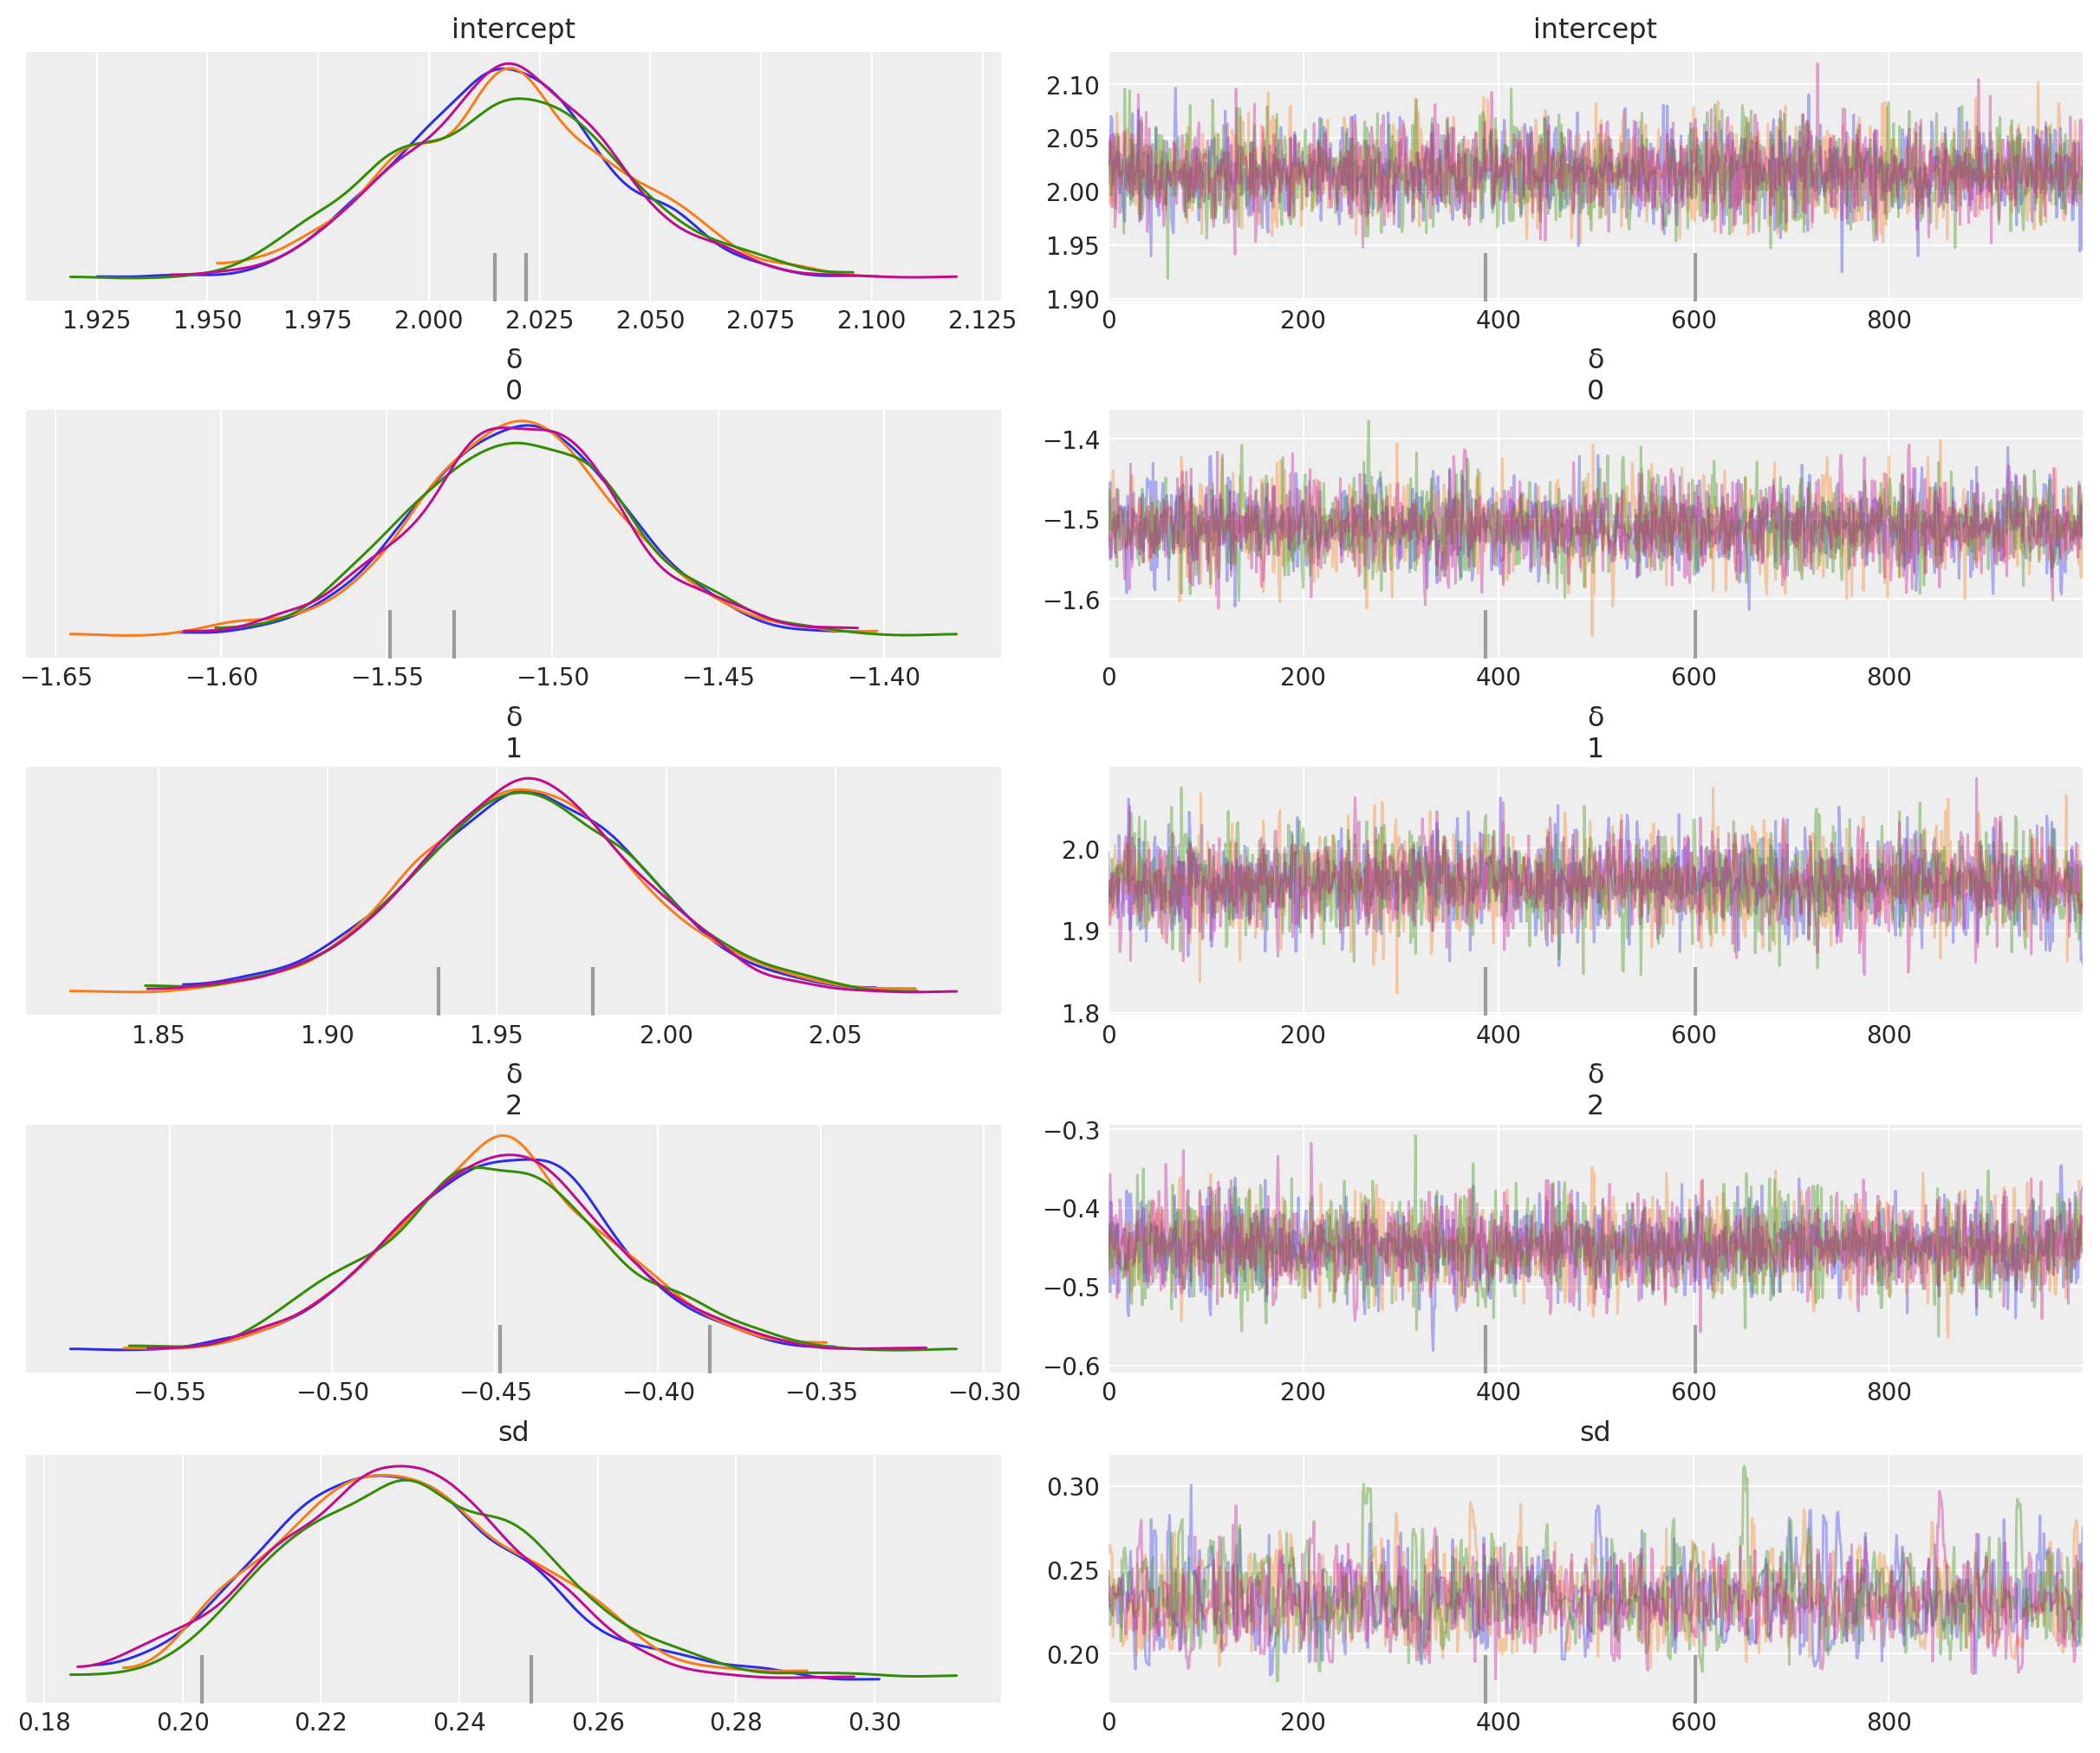

In [22]:
az.plot_trace(trace_better, compact=False, var_names=["intercept", "δ", "sd"]);

Adding in the manual sum to zero constraint for the group deflections has solved the parameter correlation issue.

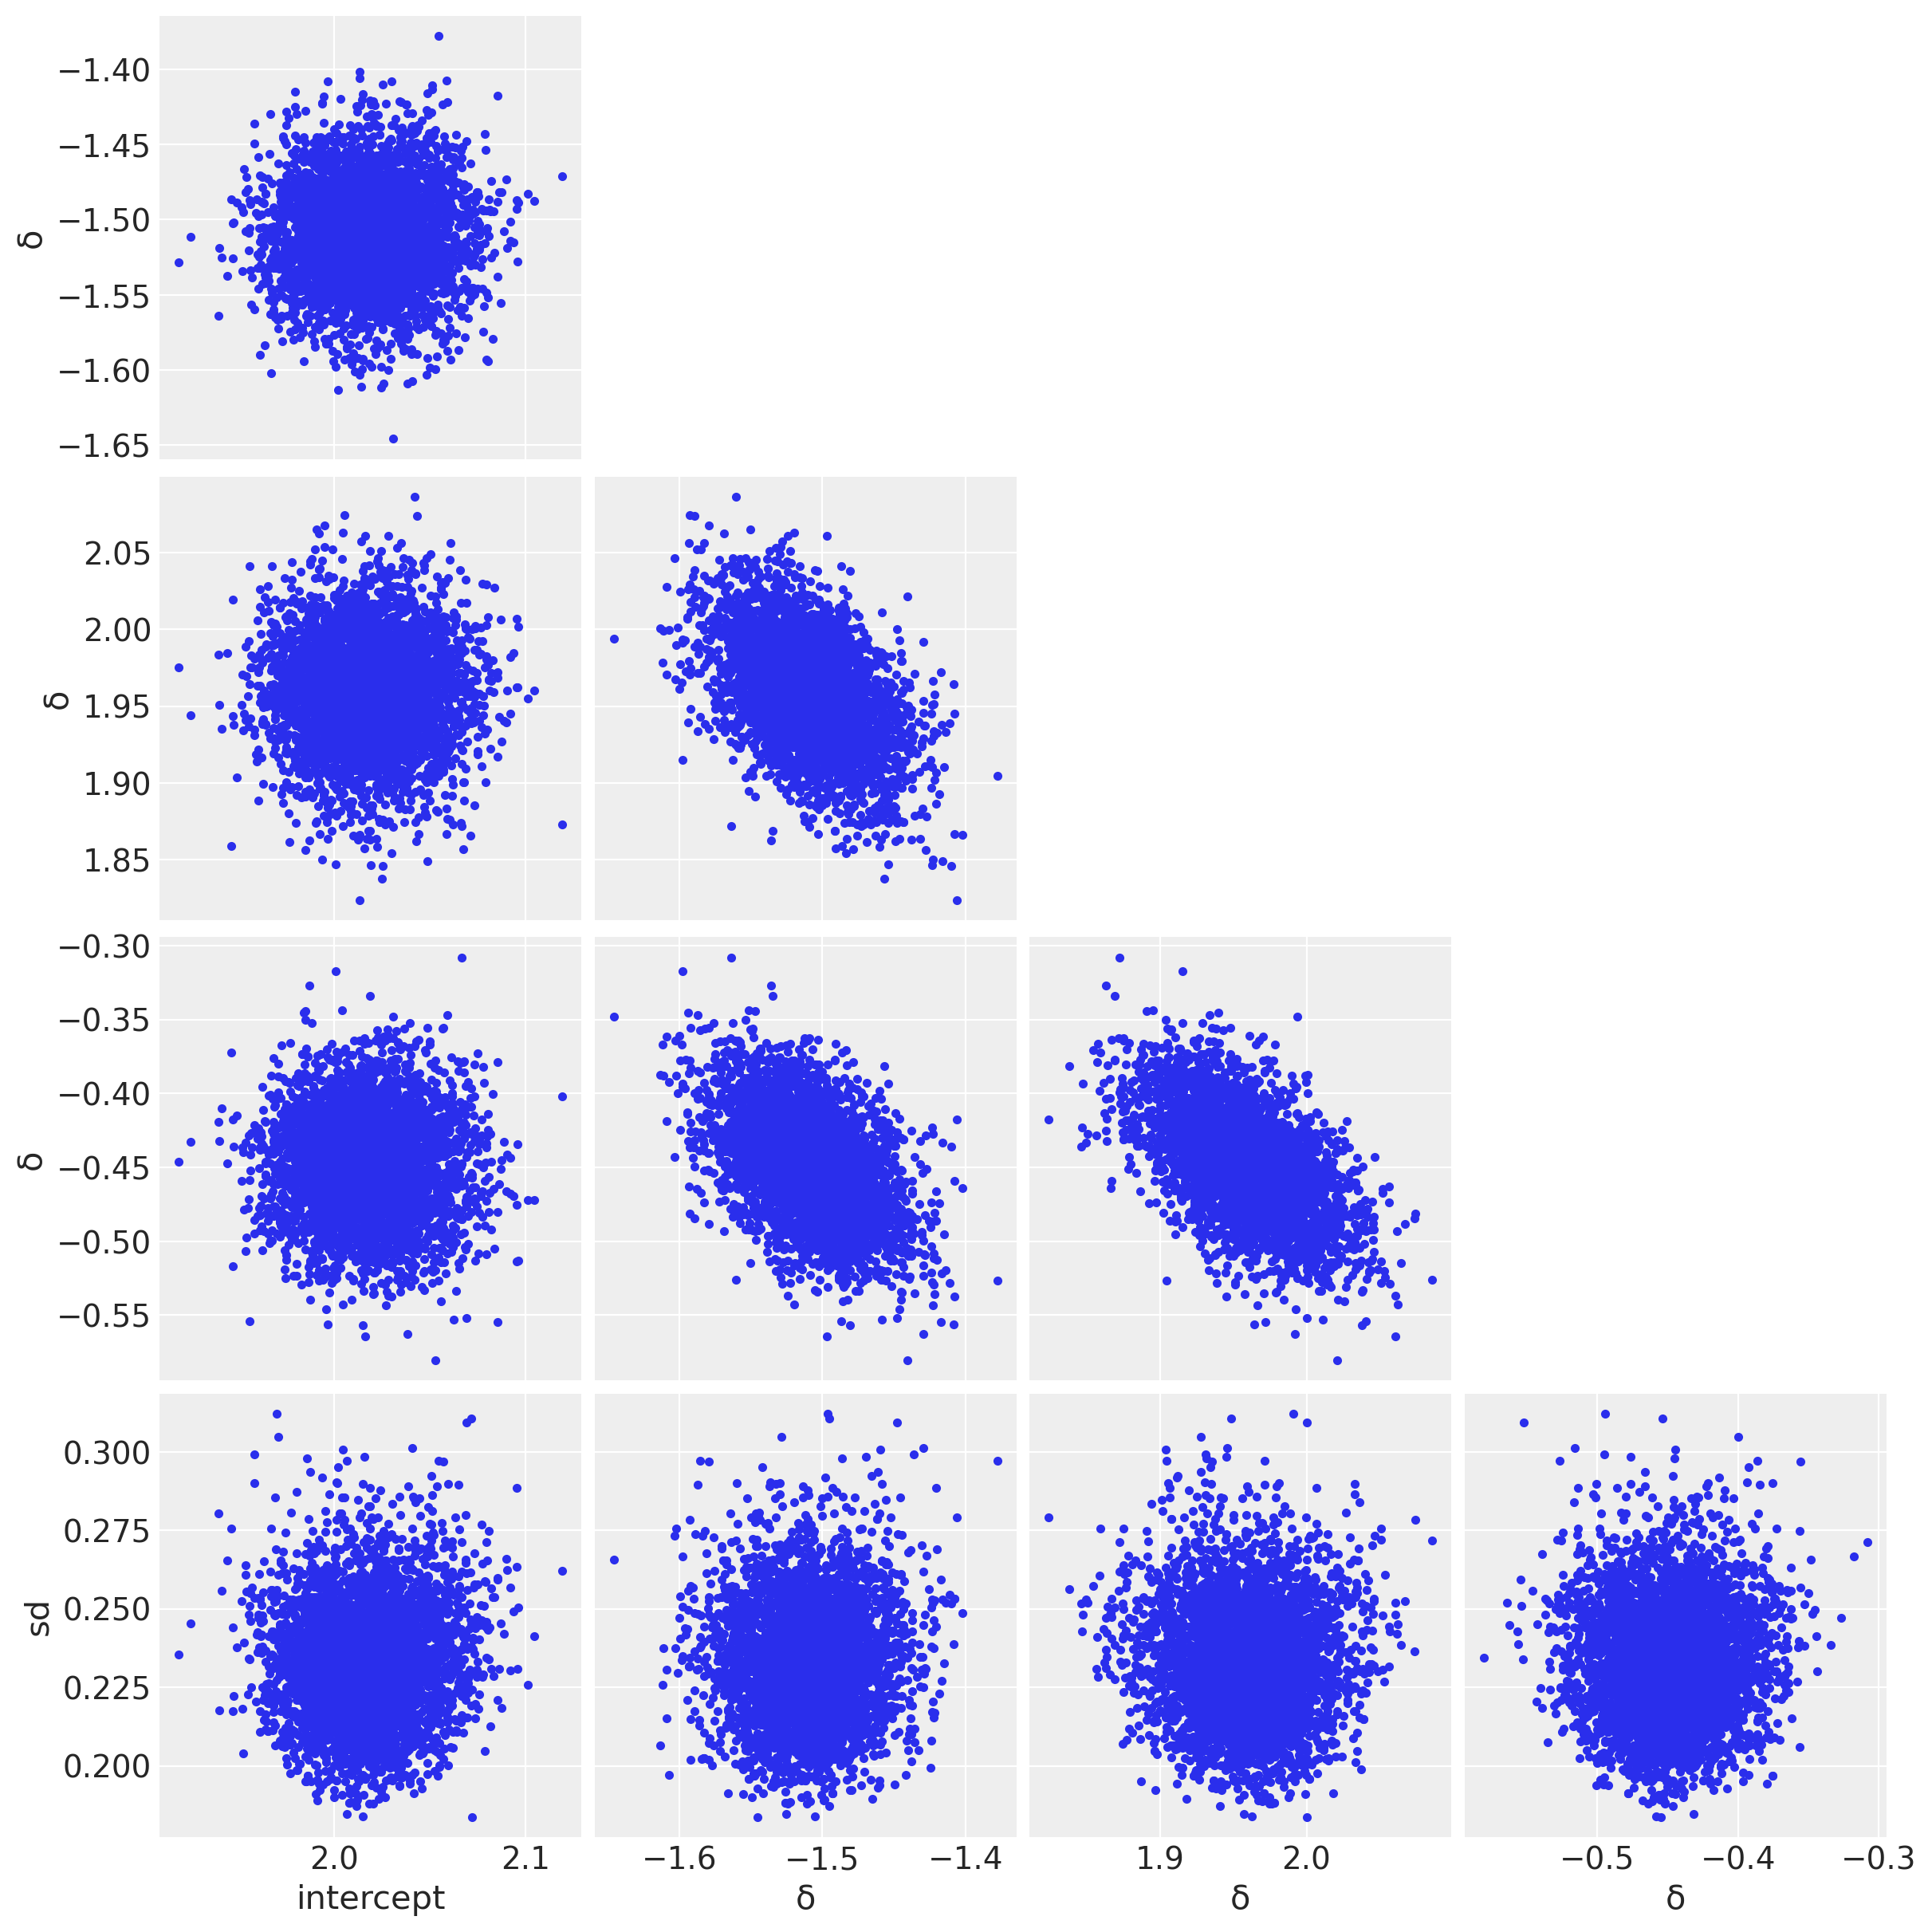

In [23]:
az.plot_pair(trace_better, var_names=["intercept", "δ", "sd"], figsize=(12, 12));

And we also have improved parameter recovery. You can compare this to the niave model implementation above - we have achieved much more precise posteriors here, as compared to that niave model.

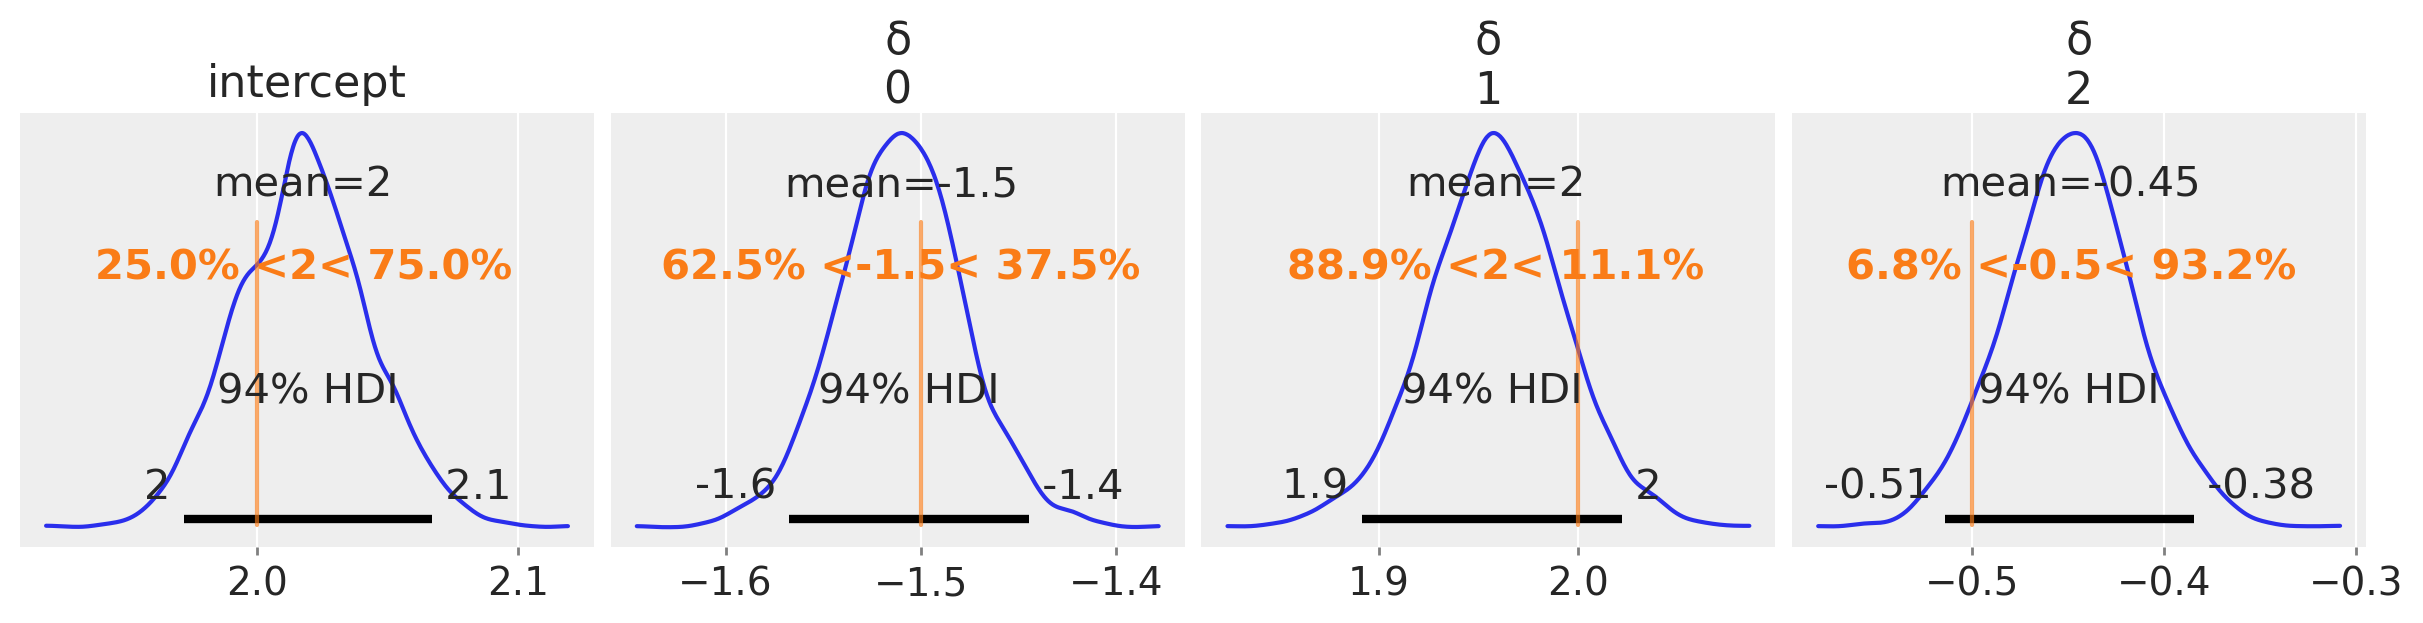

In [24]:
vals = [true["intercept"]] + list(true["δ"])
az.plot_posterior(trace_better, var_names=["intercept", "δ"], ref_val=vals, figsize=(12, 3));

Overall:
- parameter estimates are good, more precise ✅
- that the parameter correlations are now removed ✅
- low readability - the code deviates from the mathematical description ❌
- there are still divergences ❌

Maybe we could get around the divergences by increasing the number of tuning steps and target_accept, but we are getting red flags here that something could be better.

### Model with new `ZeroSumNormal` distribution
At last, we now look at a model which uses the `ZeroSumNormal` distribution and we will see that this solves all of our problems.

In [25]:
from ZeroSumNormal import ZeroSumNormal

In [26]:
with pm.Model(coords={"groups": [0, 1, 2]}) as model_centered:
    # priors
    intercept = pm.Normal("intercept", 0, 10)
    δ = ZeroSumNormal("δ", 2, dims="groups")
    sd = pm.HalfNormal("sd", 10)
    # likelihood
    obs = pm.Normal("obs", δ[df["group"]] + intercept, sd, observed=df["y"])
    trace_centered = pm.sample(return_inferencedata=True, random_seed=seed)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sd, δ, intercept]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 12 seconds.


No warnings from sampling! And it is faster than the two previous models.

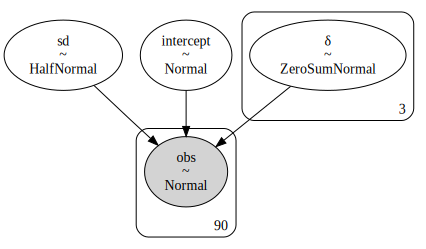

In [27]:
pm.model_graph.model_to_graphviz(model_centered)

The traces now look perfect.

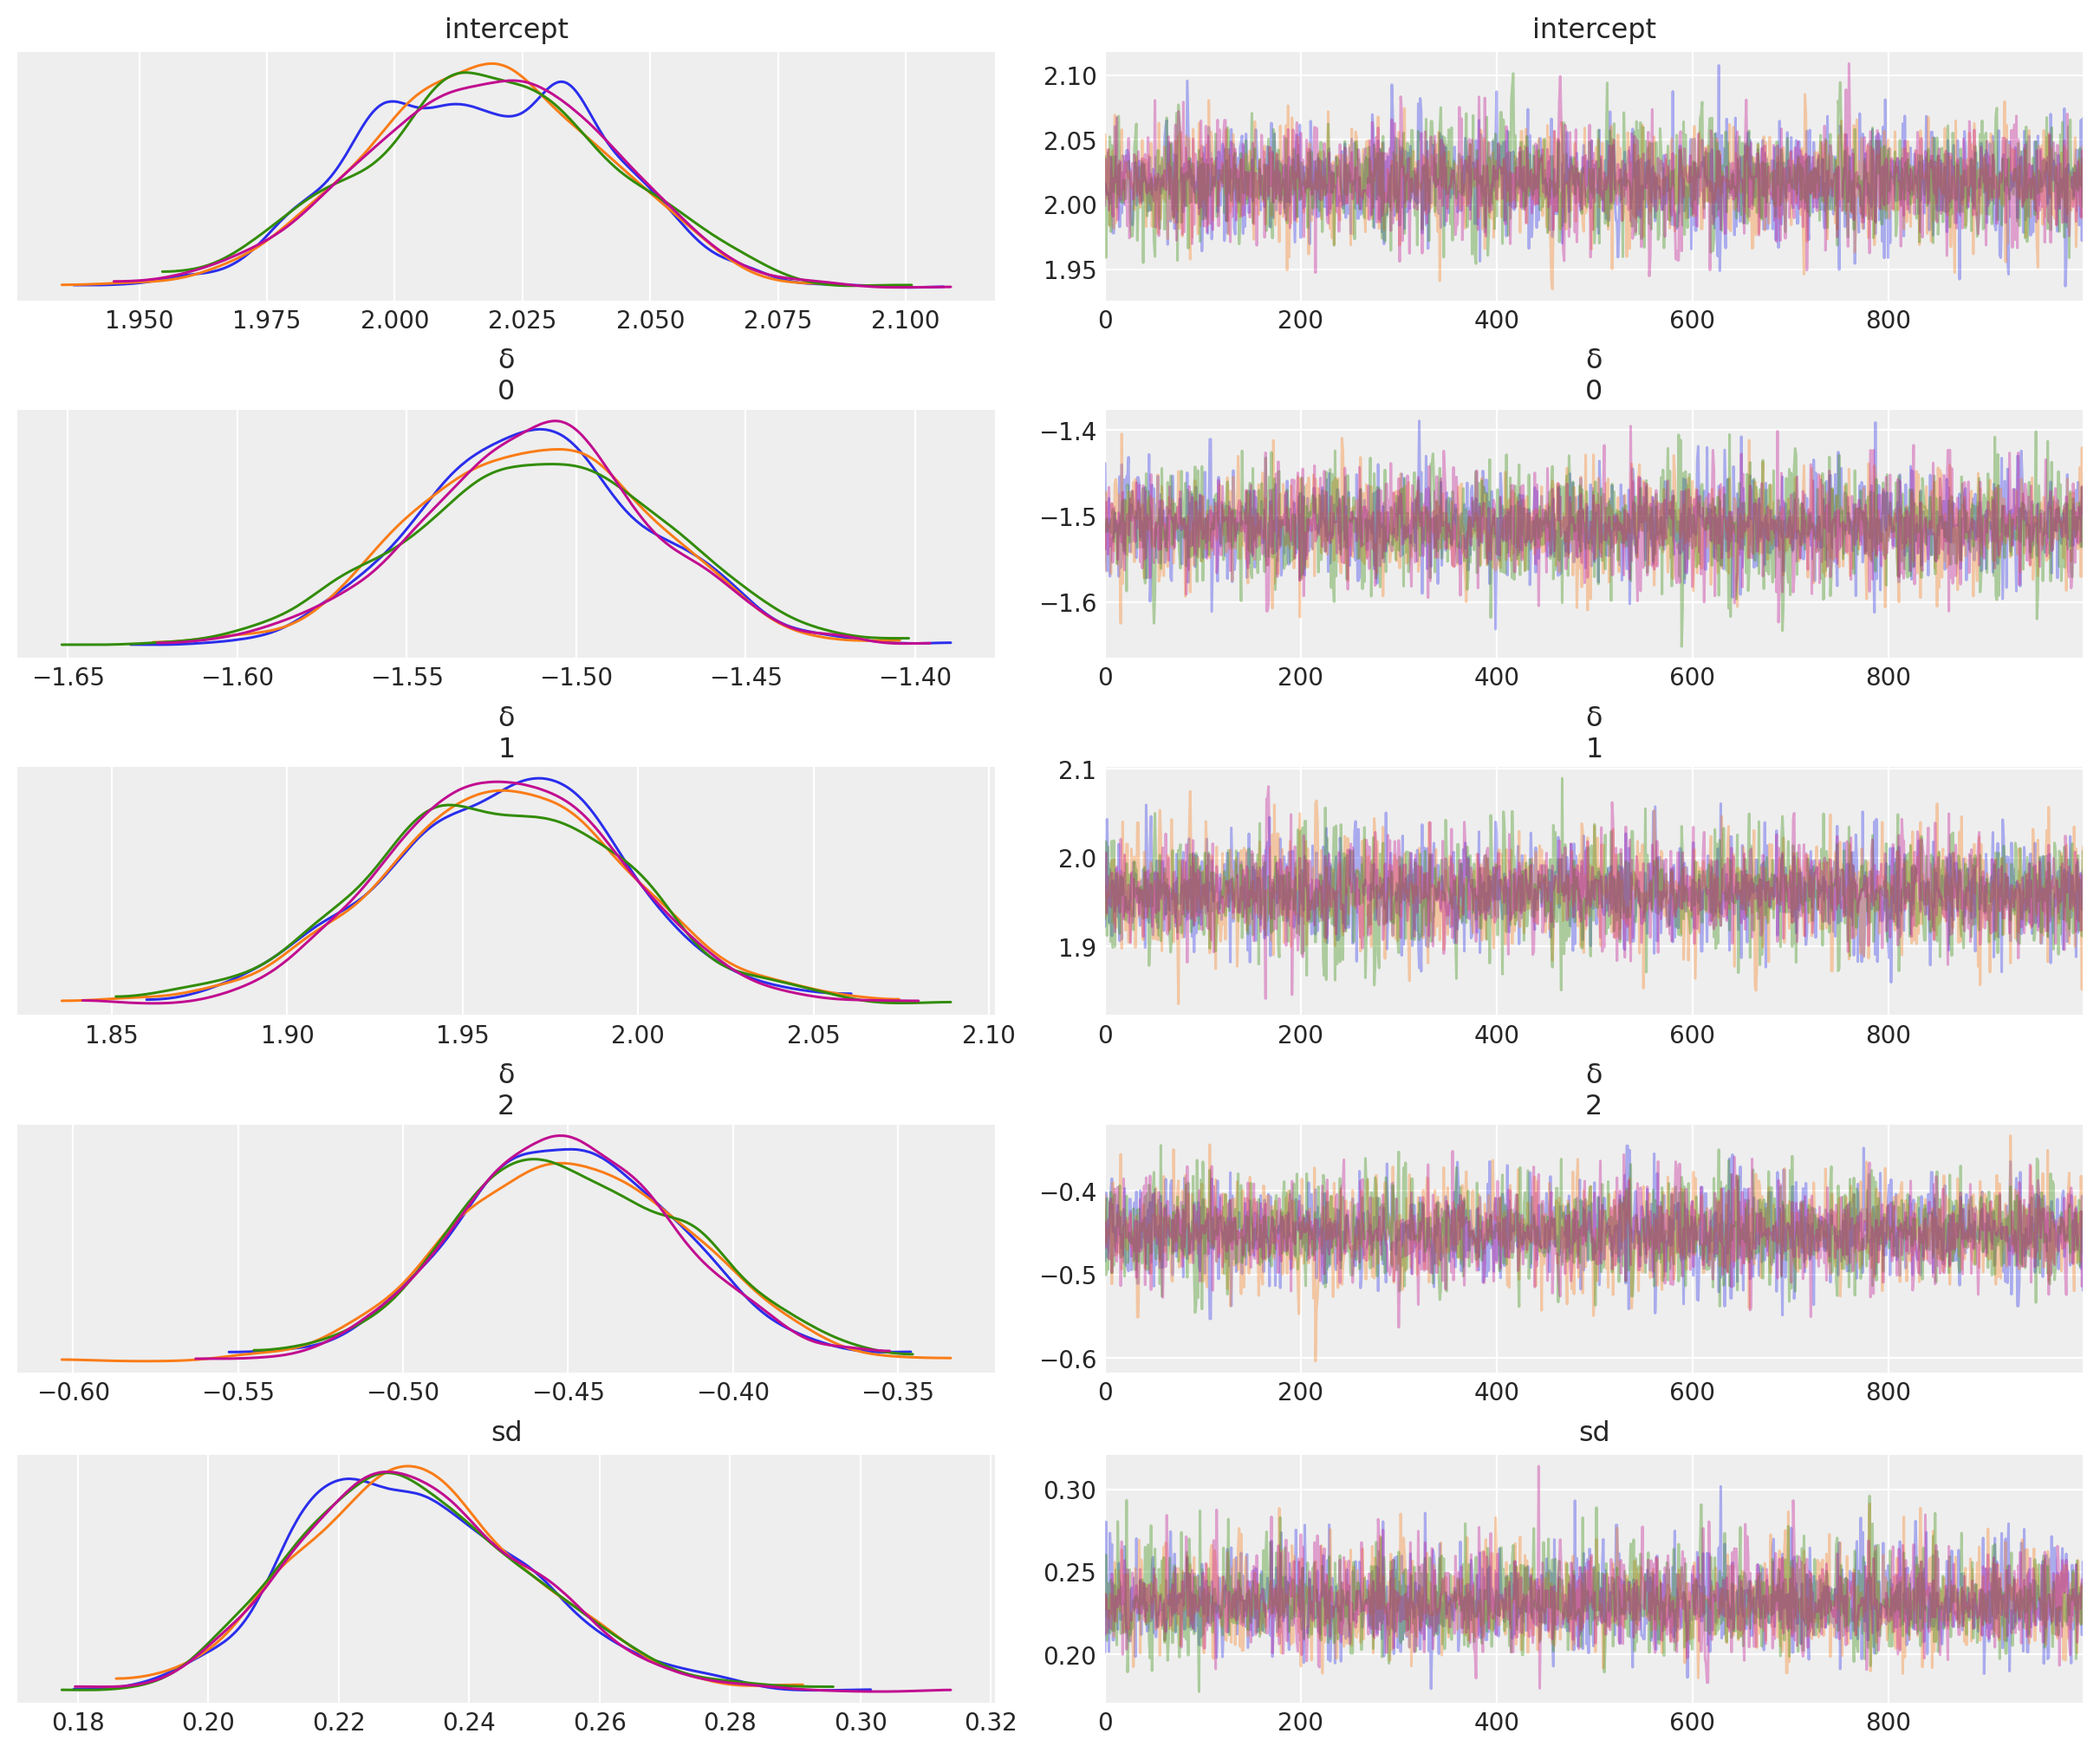

In [28]:
az.plot_trace(trace_centered, compact=False, var_names=["intercept", "δ", "sd"]);

Again, we have no concerning parameter correlations.

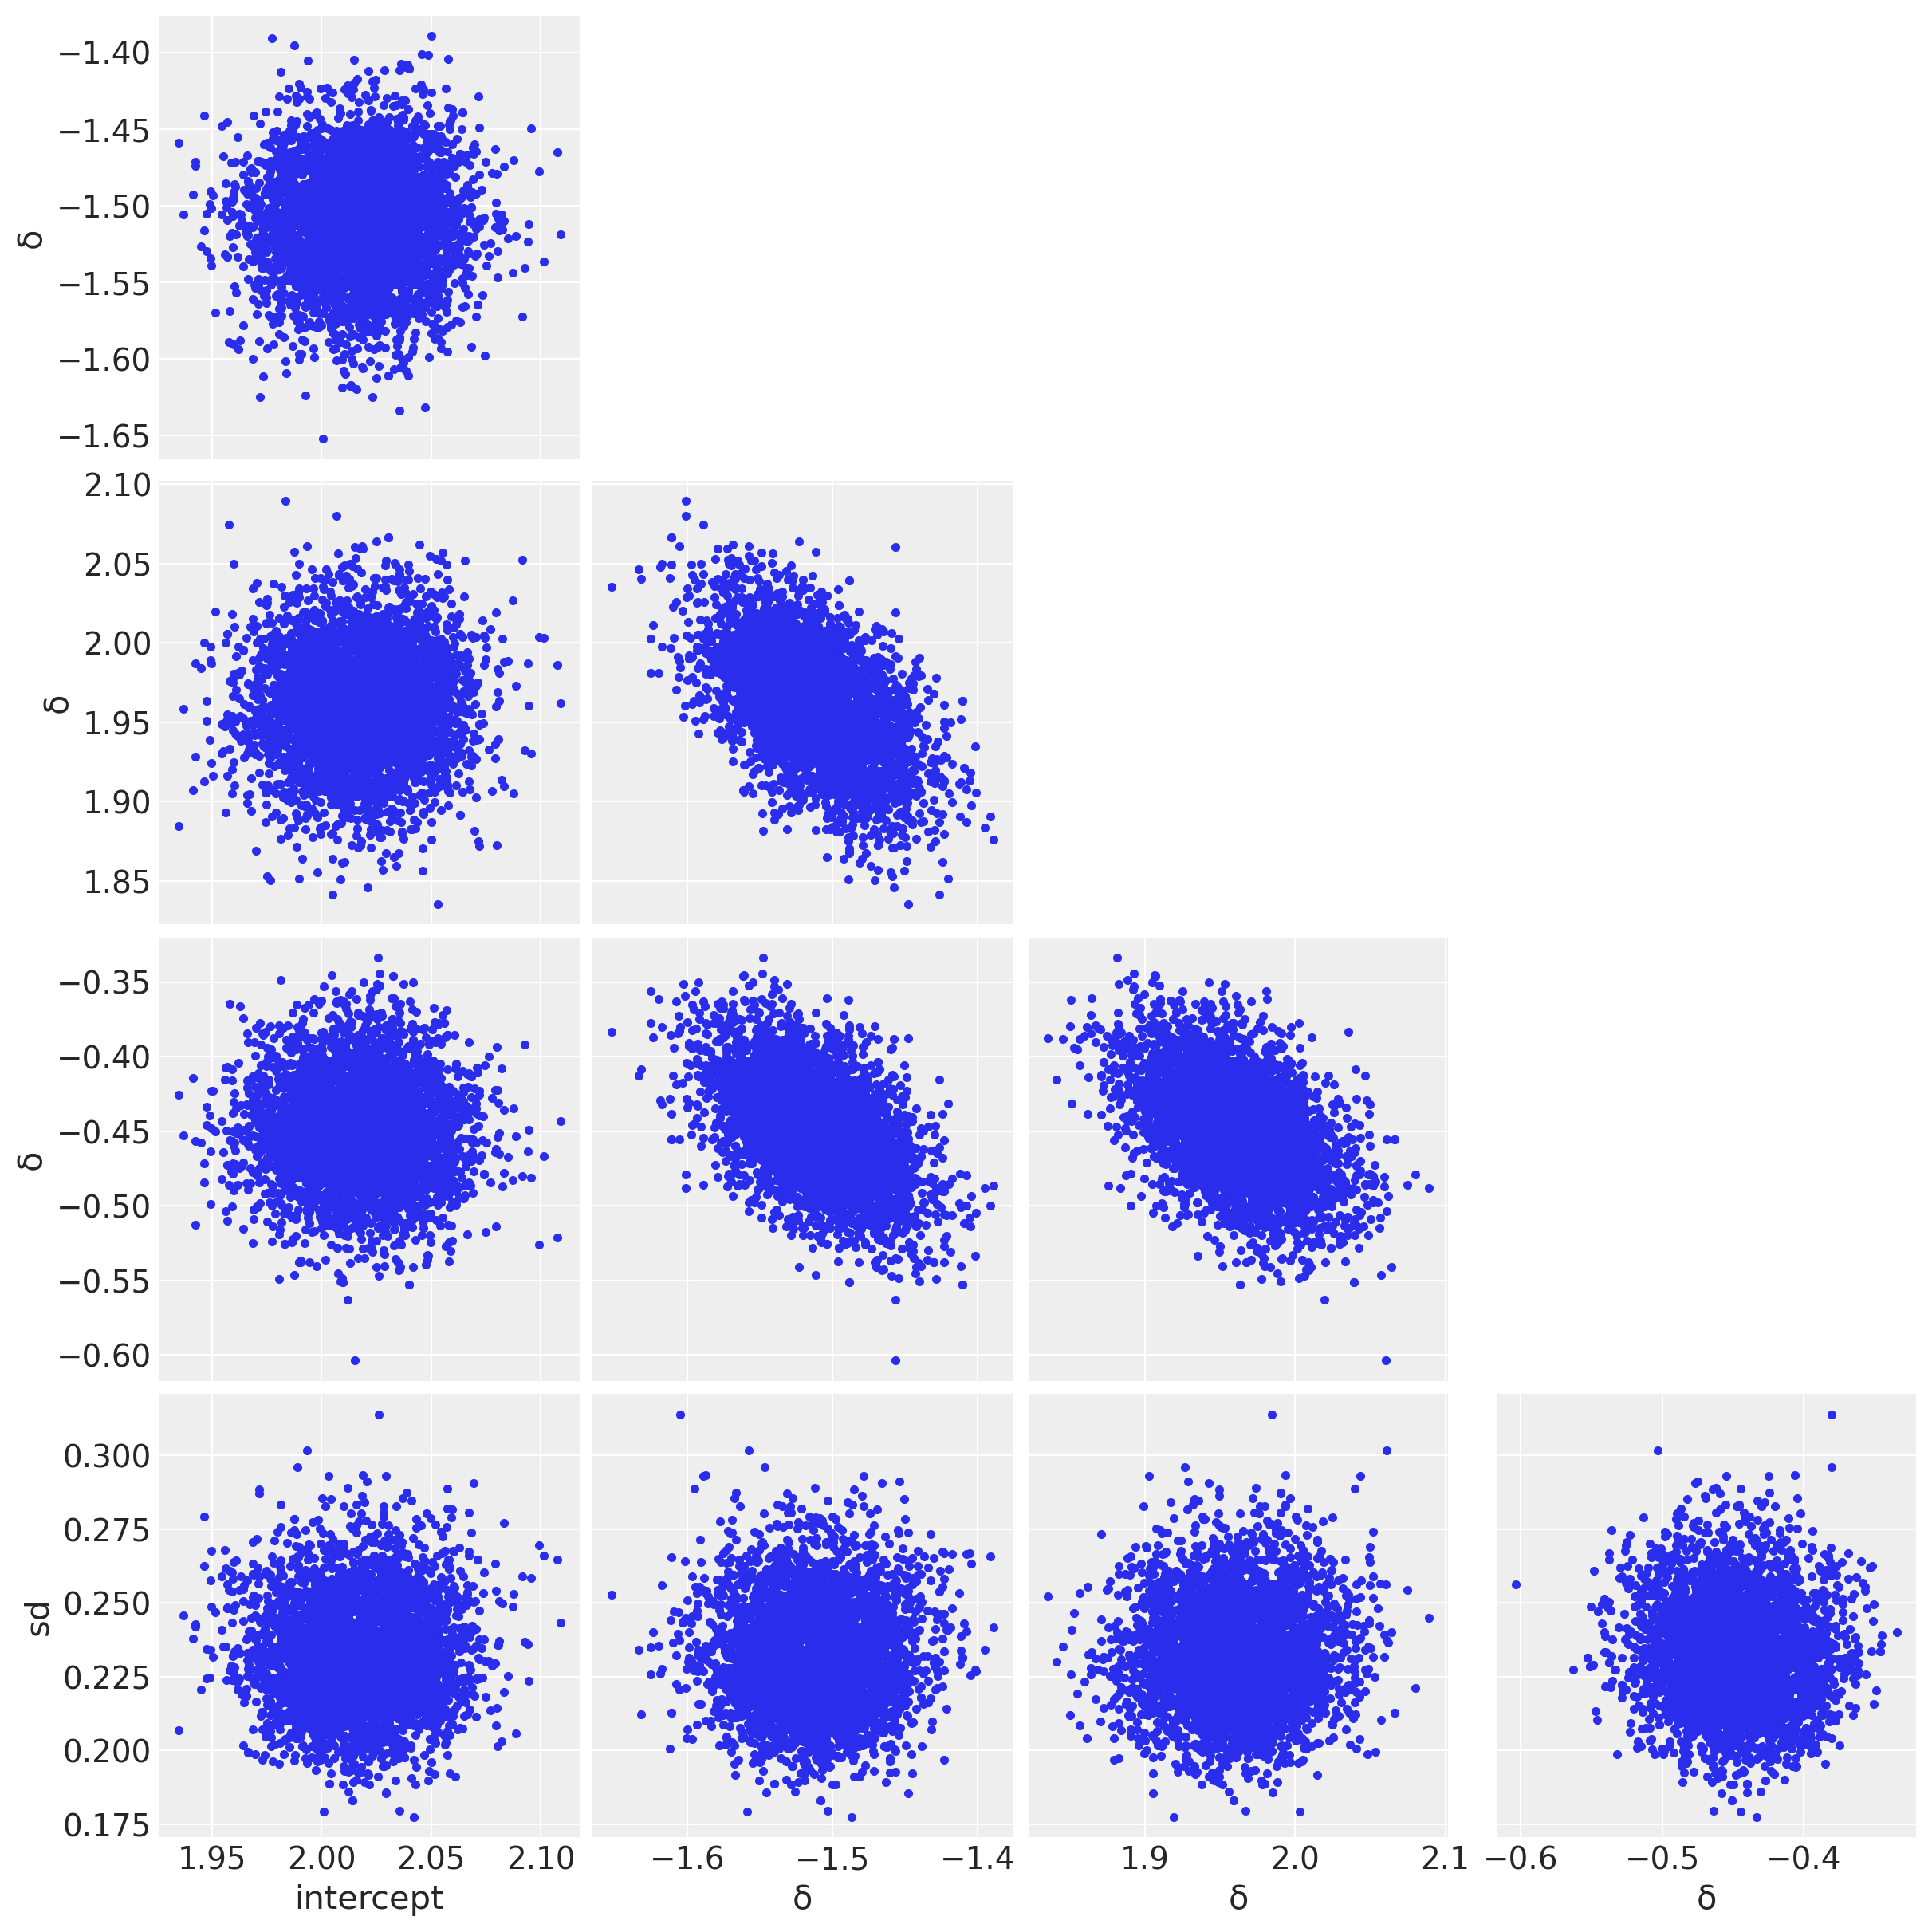

In [29]:
az.plot_pair(trace_centered, var_names=["intercept", "δ", "sd"], figsize=(12, 12));

And we can confirm that parameter recovery is good, which much greater precision than the first model.

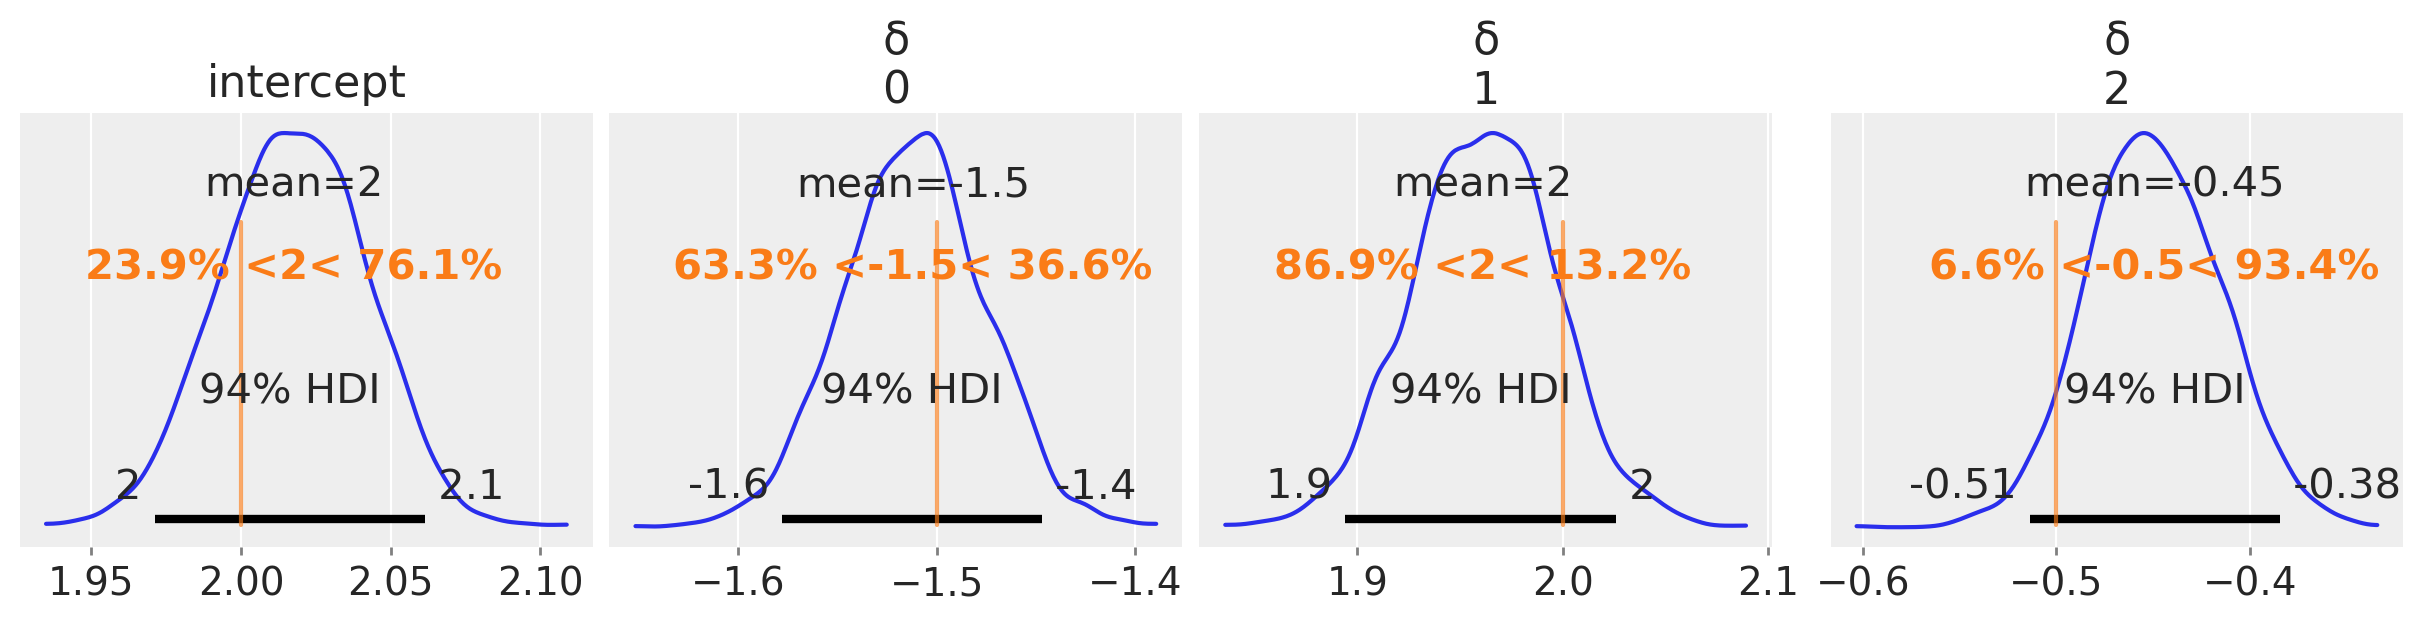

In [30]:
vals = [true["intercept"]] + list(true["δ"])
az.plot_posterior(trace_centered, var_names=["intercept", "δ"], ref_val=vals, figsize=(12, 3));

Let's just double check that the sum of the $\delta$ values generated by `ZeroSumNormal` is zero, or every MCMC sample.   

In [31]:
np.allclose(trace_centered.posterior.δ.sum("groups").values, 0.0)

True

To summarise, the model using the `ZeroSumNormal` distribution:
- the model is easier to both write and to read ✅
- has no nasty parameter correlations ✅ (just like the manual sum to zero model)
- has the best sampling properties, no divergences ✅
- it also runs faster than the niave or manual sum to zero models ✅

## [2x3 ANOVA style example?]
TODO

## [Multinomial regression example?]
TODO

In [32]:
%load_ext watermark
%watermark -n -u -v -iv -w -p theano,xarray

Last updated: Sun Sep 12 2021

Python implementation: CPython
Python version       : 3.8.11
IPython version      : 7.26.0

theano: 1.1.2
xarray: 0.16.2

statsmodels: 0.12.2
matplotlib : 3.4.2
numpy      : 1.19.2
arviz      : 0.11.0
patsy      : 0.5.1
theano     : 1.1.2
pymc3      : 3.11.1
pandas     : 1.3.1

Watermark: 2.1.0

